In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../..")

import numpy as np
import matplotlib.pyplot as plt
import os
from src import data
import json
from tqdm.auto import tqdm
from src.metrics import AggregateMetric
import logging

from src.utils import logging_utils

# logging_utils.configure(level=logging.DEBUG)

## Loading the results

In [3]:
############################################
sweep_root = "../../results/sweep-24-trials"
model_name = "gptj"
############################################

sweep_path = f"{sweep_root}/{model_name}"

In [4]:
from src.utils.sweep_utils import read_sweep_results, relation_from_dict

In [5]:
sweep_results = read_sweep_results(sweep_path)
list(sweep_results.keys())

['person occupation',
 'landmark in country',
 'adjective antonym',
 'person mother',
 'country capital city',
 'plays pro sport',
 'person plays instrument',
 'person university',
 'city in country',
 'food from country',
 'company hq',
 'occupation gender',
 'occupation age',
 'name gender',
 'word first letter',
 'country language',
 'object superclass',
 'name religion',
 'person native language',
 'president election year',
 'fruit outside color',
 'superhero archnemesis',
 'work location',
 'landmark on continent',
 'person lead singer of band',
 'task person type',
 'characteristic gender',
 'country largest city',
 'country currency',
 'fruit inside color',
 'task done by tool',
 'verb past tense',
 'star constellation name',
 'pokemon evolution',
 'president birth year',
 'product by company',
 'name birthplace',
 'word last letter',
 'word sentiment',
 'company CEO',
 'superhero person',
 'person father',
 'substance phase of matter',
 'person sport position',
 'adjective sup

In [6]:
# sweep_results_bare = read_sweep_results("../../results/sweep-bare-full-rank")
# list(sweep_results.keys())

In [41]:
relation_name = "plays pro sport"
relation_result = relation_from_dict(sweep_results[relation_name])

In [42]:
efficacy = relation_result.best_by_efficacy()
print(f"best by efficacy =>  layer={efficacy.layer}, beta={efficacy.beta.mean:.2f}, rank={efficacy.rank.mean:.0f}")
print("recall:", efficacy.recall)
print("efficacy:", efficacy.efficacy)

print("-------------------------------------------------------------")

faithfulness = relation_result.best_by_faithfulness()
print(f"best by faithfulness => layer={faithfulness.layer}, beta={faithfulness.beta.mean:.2f}, rank={faithfulness.rank.mean:.0f}")
print("recall:", faithfulness.recall)
print("efficacy:", faithfulness.efficacy)

best by efficacy =>  layer=6, beta=2.47, rank=118
recall: 0.77 ± 0.01
efficacy: 0.94 ± 0.00
-------------------------------------------------------------
best by faithfulness => layer=13, beta=2.00, rank=53
recall: 0.90 ± 0.01
efficacy: 0.85 ± 0.01


In [43]:
beta = None

efficacy = relation_result.best_by_efficacy(beta = beta)
print(f"best by efficacy =>  layer={efficacy.layer}, beta={efficacy.beta.mean:.2f}, rank={efficacy.rank.mean:.0f}")
print("recall:", efficacy.recall)
print("efficacy:", efficacy.efficacy)

print("-------------------------------------------------------------")

faithfulness = relation_result.best_by_faithfulness(beta = beta)
print(f"best by faithfulness => layer={faithfulness.layer}, beta={faithfulness.beta.mean:.2f}, rank={faithfulness.rank.mean:.0f}")
print("recall:", faithfulness.recall)
print("efficacy:", faithfulness.efficacy)

best by efficacy =>  layer=6, beta=2.47, rank=118
recall: 0.77 ± 0.01
efficacy: 0.94 ± 0.00
-------------------------------------------------------------
best by faithfulness => layer=13, beta=2.00, rank=53
recall: 0.90 ± 0.01
efficacy: 0.85 ± 0.01


In [44]:
##############################################################################
fig_dir = f"figs/{model_name}"
##############################################################################

In [45]:
plt.rcdefaults()
os.makedirs(fig_dir, exist_ok=True)
#####################################################################################
plt.rcdefaults()
plt.rcParams["figure.dpi"] = 200
plt.rcParams["font.family"] = "Times New Roman"

SMALL_SIZE = 14
MEDIUM_SIZE = 18
BIGGER_SIZE = 22

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", labelsize=MEDIUM_SIZE+1)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=MEDIUM_SIZE - 2)  # legend fontsize
plt.rc("figure", titlesize=50)  # fontsize of the figure title
#####################################################################################

color_scheme = {
    "recall": "darkblue",
    "efficacy": "darkorange",
}

legend_labels = {
    "recall": "Faithfulness",
    "efficacy": "Causality",
}

def plot_layerwise(canvas, relation_result, attribute = "recall", best_criterion = "faithfulness"):
    by_layer = relation_result.by_layer()

    layers = list(by_layer.keys())
    value_means = [value.__dict__[attribute].mean for value in by_layer.values()]
    value_stds = [value.__dict__[attribute].stdev for value in by_layer.values()]

    if(best_criterion == "faithfulness"):
        best_layer = relation_result.best_by_faithfulness()
    elif(best_criterion == "efficacy"):
        best_layer = relation_result.best_by_efficacy()
    # canvas.scatter([layers.index(best_layer.layer)], [best_layer.__dict__[attribute].mean], color="red", s=200)
    canvas.plot(range(len(layers)), value_means, color=color_scheme[attribute], linewidth=1.5, label = legend_labels[attribute])
    canvas.fill_between(range(len(layers)), np.array(value_means) - np.array(value_stds), np.array(value_means) + np.array(value_stds), color=color_scheme[attribute], alpha=0.1)

    if attribute in ["recall", "efficacy"]:
        canvas.set_ylim(0, 1)
    else:
        canvas.set_ylim(bottom=0)
    canvas.set_xlabel("Layer")
    canvas.set_ylabel(attribute)
    canvas.set_xticks(range(len(layers)), layers, rotation=90)
    test_samples = [trial.n_test_samples for trial in relation_result.trials]
    test_samples = np.array(test_samples)
    trial_info = f"[{test_samples.mean():.2f} ± {test_samples.std():.2f}]"
    canvas.set_title(f"{relation_result.relation_name} n_trials={len(test_samples)} {trial_info}\n{best_criterion} => h_layer: {best_layer.layer}, beta: {best_layer.beta.mean:.2f}, rank: {best_layer.rank.mean:.2f}, efficacy: {best_layer.efficacy.mean:.2f}")
    
    return canvas

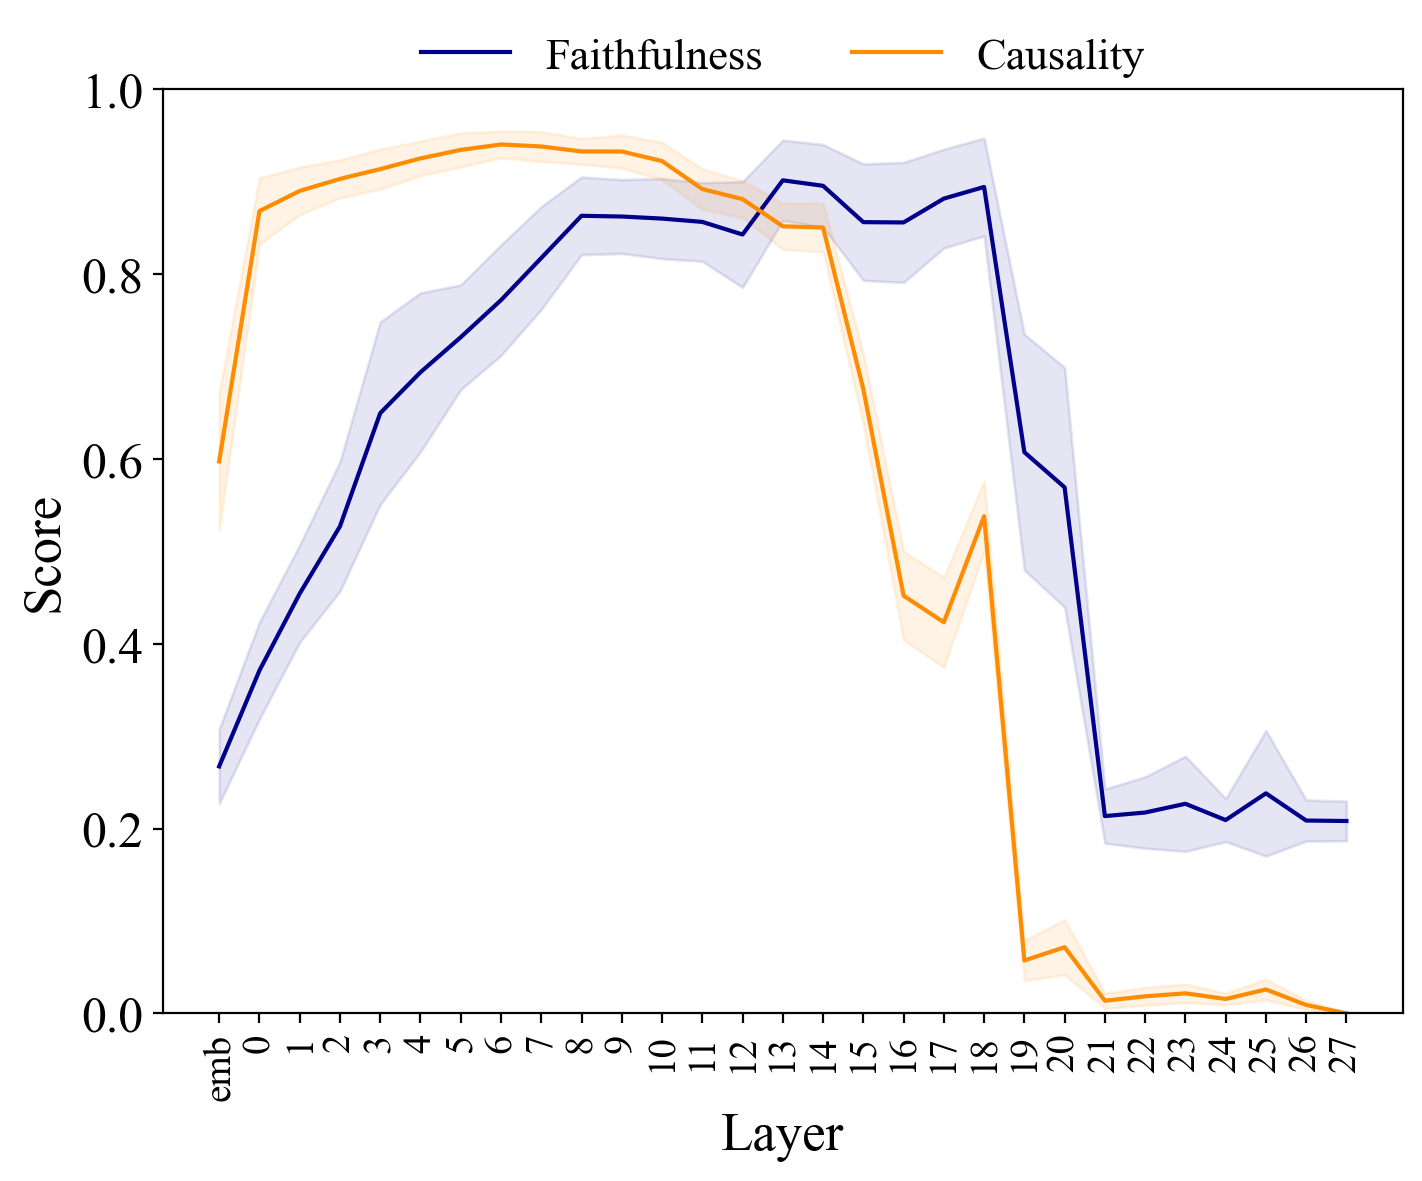

In [46]:
nrows = 1
ncols = 1
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 8, nrows * 6))
plot_layerwise(ax, relation_result)
plot_layerwise(ax, relation_result, attribute="efficacy", best_criterion="efficacy")
ax.set_ylabel("Score")
ax.set_title("", fontsize=BIGGER_SIZE, pad=10)
plt.legend(ncol = 2, bbox_to_anchor=(0.5, 1.1), loc='upper center', frameon=False)

plt.savefig(f"{fig_dir}/{model_name}-sweep-not-bare.pdf", bbox_inches="tight")
plt.show()

In [13]:
dataset = data.load_dataset()
all_relations = [
    relation.name for relation in dataset.relations
]
all_relations = sorted(all_relations)
# all_relations
failed_relations = list(set(all_relations) - set(sweep_results.keys()))
failed_relations = sorted(failed_relations)

failed_relations

[]

In [14]:
# ############################################
# efficacy_root = "../../results/efficacy_baselines-24-trials"
# ############################################""

# efficacy_path = f"{efficacy_root}/{model_name}"

In [15]:
# def read_efficacy_baseline_results(sweep_path):
#     efficacy_baseline_results = {}

#     for relation_folder in os.listdir(sweep_path):
#         cur_sweep = f"{sweep_path}/{relation_folder}"
#         if "results_all.json" not in os.listdir(cur_sweep):
#             continue
#         with open(f"{cur_sweep}/results_all.json") as f:
#             res = json.load(f)["relations"]
#             if(len(res) == 0 or len(res[0]["trials"]) ==  0):
#                 continue
#             res = res[0]
#             efficacy_baseline_results[res["relation_name"]] = res
#     return efficacy_baseline_results

# efficacy_baseline_results = read_efficacy_baseline_results(efficacy_path)

# print(len(efficacy_baseline_results))
# list(efficacy_baseline_results.keys())

In [16]:
# def parse_efficacy_baseline_results(efficacy_result):
#     layerwise_results = {}
#     for trial in efficacy_result["trials"]:
#         for layer in trial["layerwise_baseline_results"]:
#             layer_name = layer["layer"]
#             if layer_name not in layerwise_results:
#                 layerwise_results[layer_name] = {
#                     edit_type: [] for edit_type in layer["results"].keys()
#                 }
#                 layerwise_results[layer_name]
#             for edit_type in layer["results"].keys():
#                 layerwise_results[layer_name][edit_type].append(layer['results'][edit_type])
    
#     for layer_name in layerwise_results.keys():
#         for edit_type in layerwise_results[layer_name].keys():
#             layerwise_results[layer_name][edit_type] = AggregateMetric.aggregate(layerwise_results[layer_name][edit_type])
        
#     return {
#         "relation_name": efficacy_result["relation_name"],
#         "layerwise_result": layerwise_results
#     }

In [17]:
# relation_name = "work location"
# relation_result = relation_from_dict(sweep_results[relation_name])
# # parse_efficacy_baseline_results(
# #     efficacy_baseline_results[relation_name]
# # )

In [18]:
# color_dict = {
#     # "low_rank_pinv": "darkblue",
#     "hidden_baseline": "darkgreen",
#     "embed_baseline": "darkred",
#     "hidden_baseline_z": "blue"
# }

# edit_type_legends = {
#     # "low_rank_pinv": "Efficacy",
#     "hidden_baseline"   : "Replacing with s′",
#     "embed_baseline"    : "Replacing with e",
#     "hidden_baseline_z" : "Replacing with o′"
# }

# def plot_efficacy_baseline(ax, efficacy_result):
#     layerwise_result = efficacy_result["layerwise_result"]
#     layers = list(layerwise_result.keys())
#     edit_types = list(layerwise_result[layers[0]].keys())

#     for edit_type in edit_types:
#         if(edit_type not in color_dict):
#             continue
#         ax.plot(
#             range(len(layers)),
#             [layerwise_result[layer][edit_type].mean for layer in layers],
#             label=edit_type_legends[edit_type],
#             color=color_dict[edit_type],
#             alpha=0.7,
#             linestyle='--'
#         )
#         ax.fill_between(
#             range(len(layers)),
#             [layerwise_result[layer][edit_type].mean - layerwise_result[layer][edit_type].stdev for layer in layers],
#             [layerwise_result[layer][edit_type].mean + layerwise_result[layer][edit_type].stdev for layer in layers],
#             alpha=0.1,
#             color=color_dict[edit_type]
#         )
#     ax.set_xticks(range(len(layers)))
#     ax.set_xticklabels(layers)
#     ax.legend()
#     ax.set_xlabel("Layer")
#     ax.set_ylabel("Efficacy")
#     if(ax.get_title() == ""):
#         ax.set_title(efficacy_result["relation_name"])



# efficacy_result = parse_efficacy_baseline_results(
#     efficacy_baseline_results[relation_name]
# )

# # fig, ax = plt.subplots(figsize=(10, 5))
# # plot_efficacy_baseline(ax, efficacy_result)

In [19]:
# plt.rcdefaults()
# #####################################################################################
# plt.rcdefaults()
# plt.rcParams["figure.dpi"] = 200
# plt.rcParams["font.family"] = "Times New Roman"

# SMALL_SIZE = 14
# MEDIUM_SIZE = 18
# BIGGER_SIZE = 22

# plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
# plt.rc("axes", labelsize=MEDIUM_SIZE+1)  # fontsize of the x and y labels
# plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
# plt.rc("ytick", labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
# plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
# plt.rc("figure", titlesize=50)  # fontsize of the figure title
# #####################################################################################

# nrows = 1
# ncols = 1
# fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 8, nrows * 6))
# plot_layerwise(ax, relation_result, attribute="efficacy", best_criterion="efficacy")
# plot_efficacy_baseline(ax, efficacy_result)
# ax.set_ylabel("Success @ 1")
# ax.set_title(relation_name, fontsize=BIGGER_SIZE, pad=10)
# ax.legend(ncol = 1, bbox_to_anchor=(1, 1), loc='upper right')

# plt.savefig(f"{fig_dir}/{model_name}-causality_baselines.pdf", bbox_inches="tight")
# plt.show()

In [20]:
# ranks = {
#     layer : layer_summary.rank.values
#     for layer, layer_summary in relation_result.by_layer().items()
# }
# ranks

In [21]:
dataset = data.load_dataset()
interested_dataset = dataset.filter(
    # relation_type = ["factual"]
)

filtered_results = {}
for relation_name in tqdm(interested_dataset.relations):
    if relation_name.name not in sweep_results:
        continue
    relation_result = relation_from_dict(sweep_results[relation_name.name])
    if len(relation_result.trials) < (3 if model_name != "llama-13b" else 2):
        print(f"skipping {relation_name.name}, not enough trials, : {[trial.n_test_samples for trial in relation_result.trials]}")
        continue
    filtered_results[relation_name.name] = relation_result

  0%|          | 0/47 [00:00<?, ?it/s]

skipping univ degree gender, not enough trials, : [20, 19]


## Sweep Figures

0 characteristic gender
1 name birthplace
2 name gender


/tmp/ipykernel_14160/2810301633.py:29: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


3 name religion
4 occupation age
5 occupation gender
6 person native language
7 fruit inside color
8 fruit outside color
9 object superclass
10 substance phase of matter
11 task person type
12 task done by tool
13 word sentiment
14 work location
15 city in country
16 company CEO
17 company hq
18 country capital city
19 country currency
20 country language
21 country largest city
22 food from country
23 landmark in country
24 landmark on continent
25 person lead singer of band
26 person father
27 person mother
28 person occupation
29 person plays instrument
30 person sport position
31 plays pro sport
32 person university
33 pokemon evolution
34 president birth year
35 president election year
36 product by company
37 star constellation name
38 superhero archnemesis
39 superhero person
40 adjective antonym
41 adjective comparative
42 adjective superlative
43 verb past tense
44 word first letter
45 word last letter


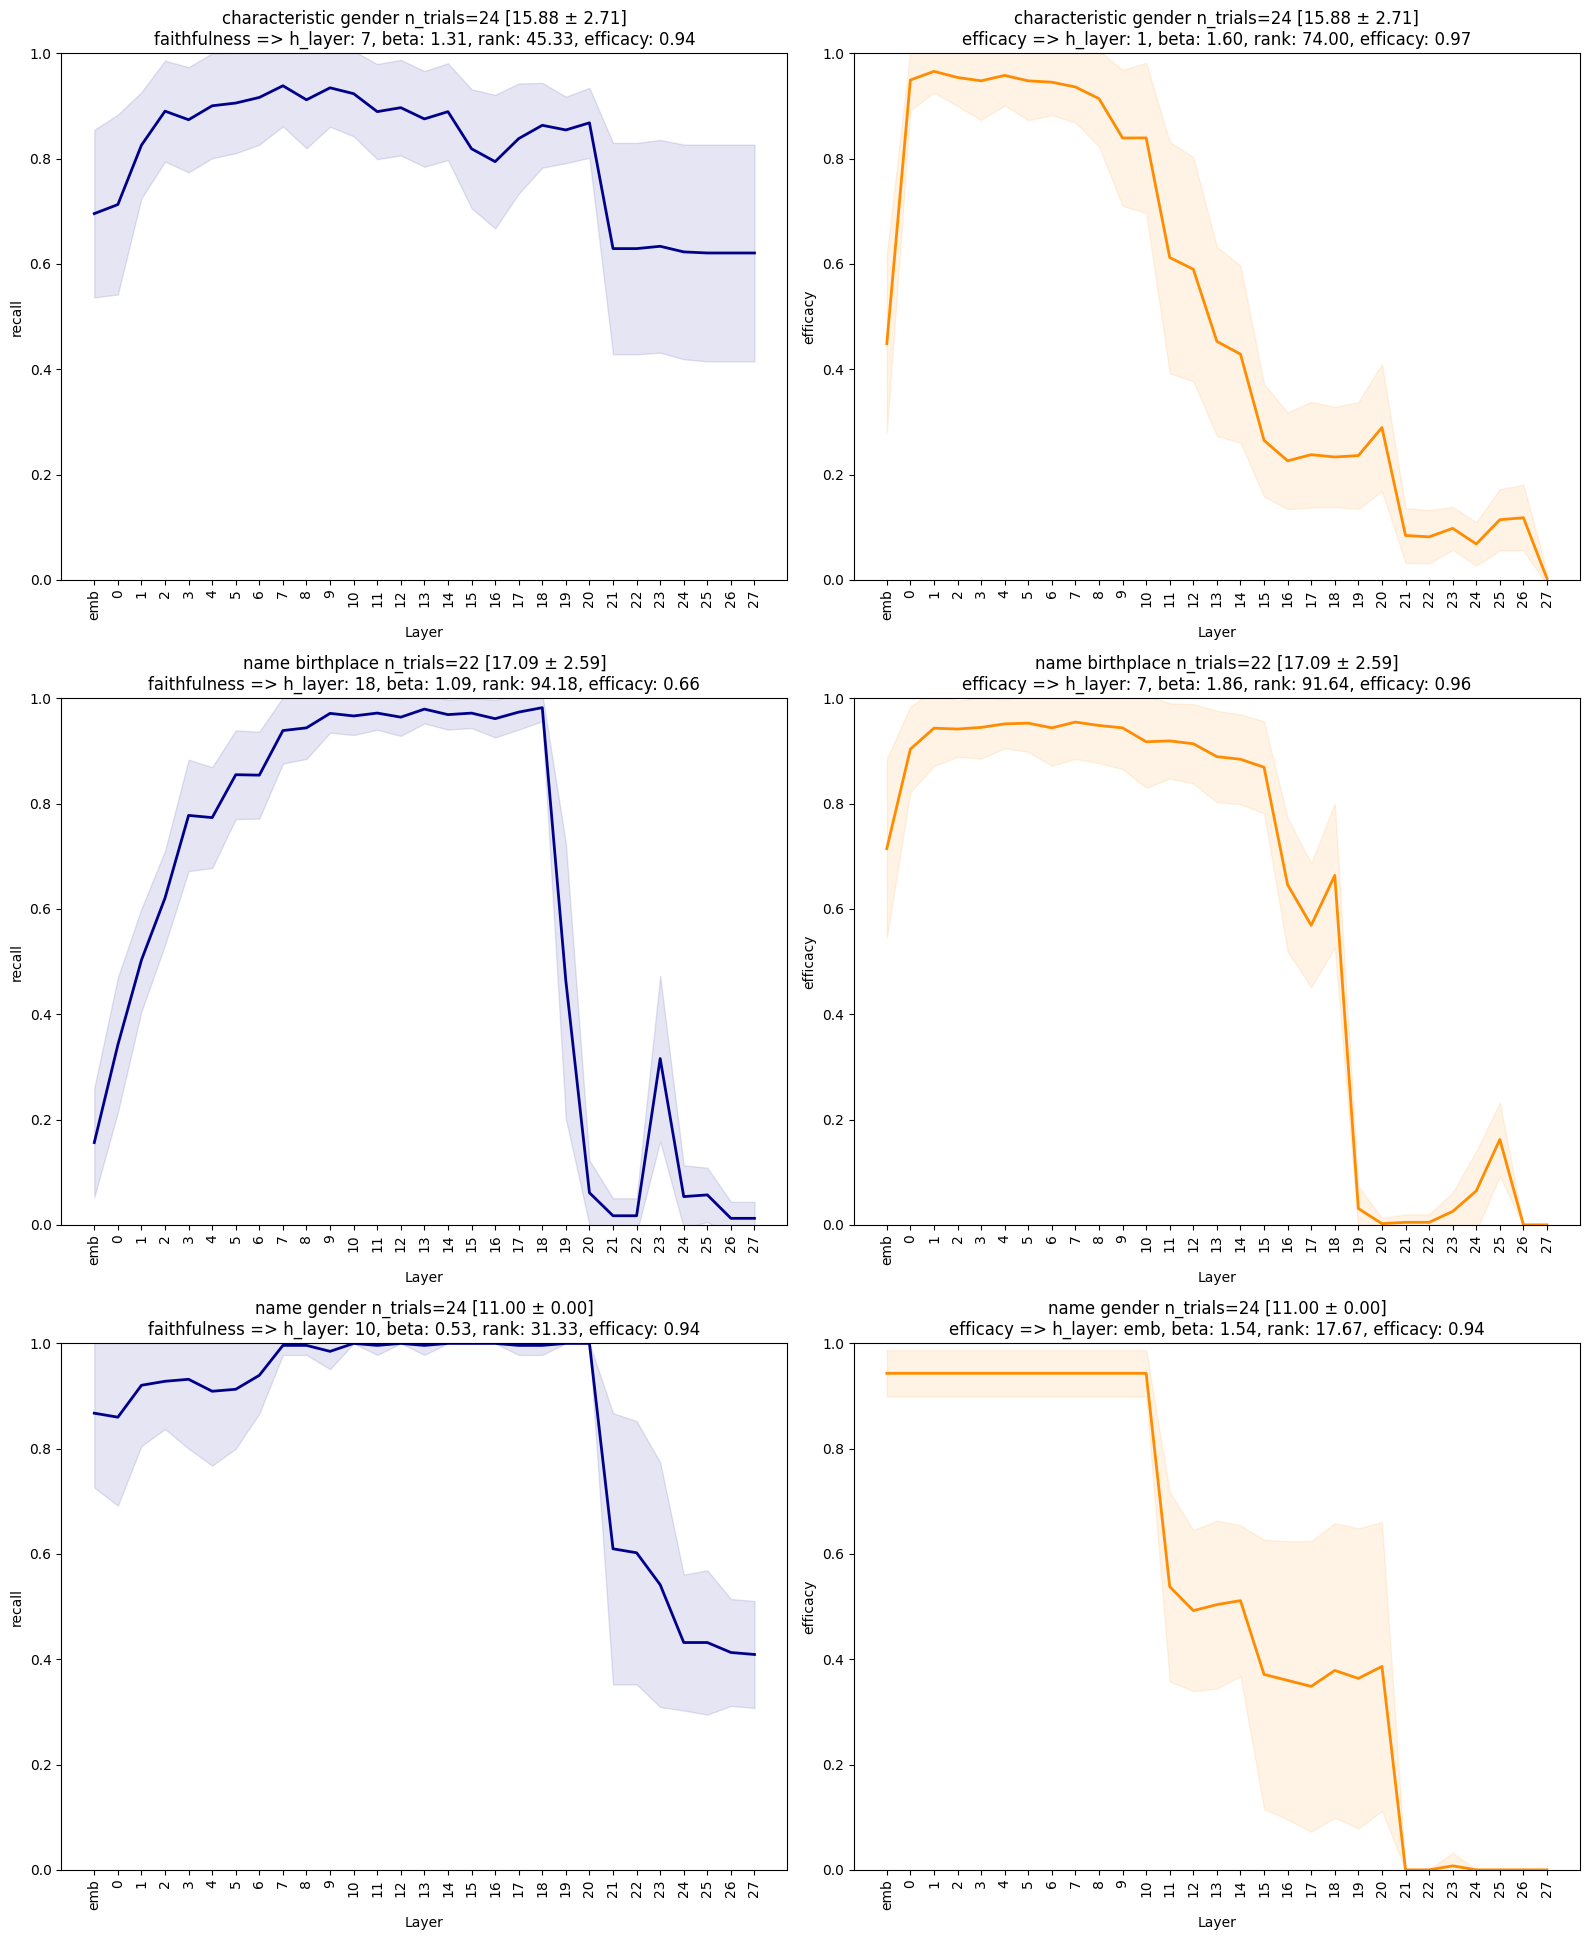

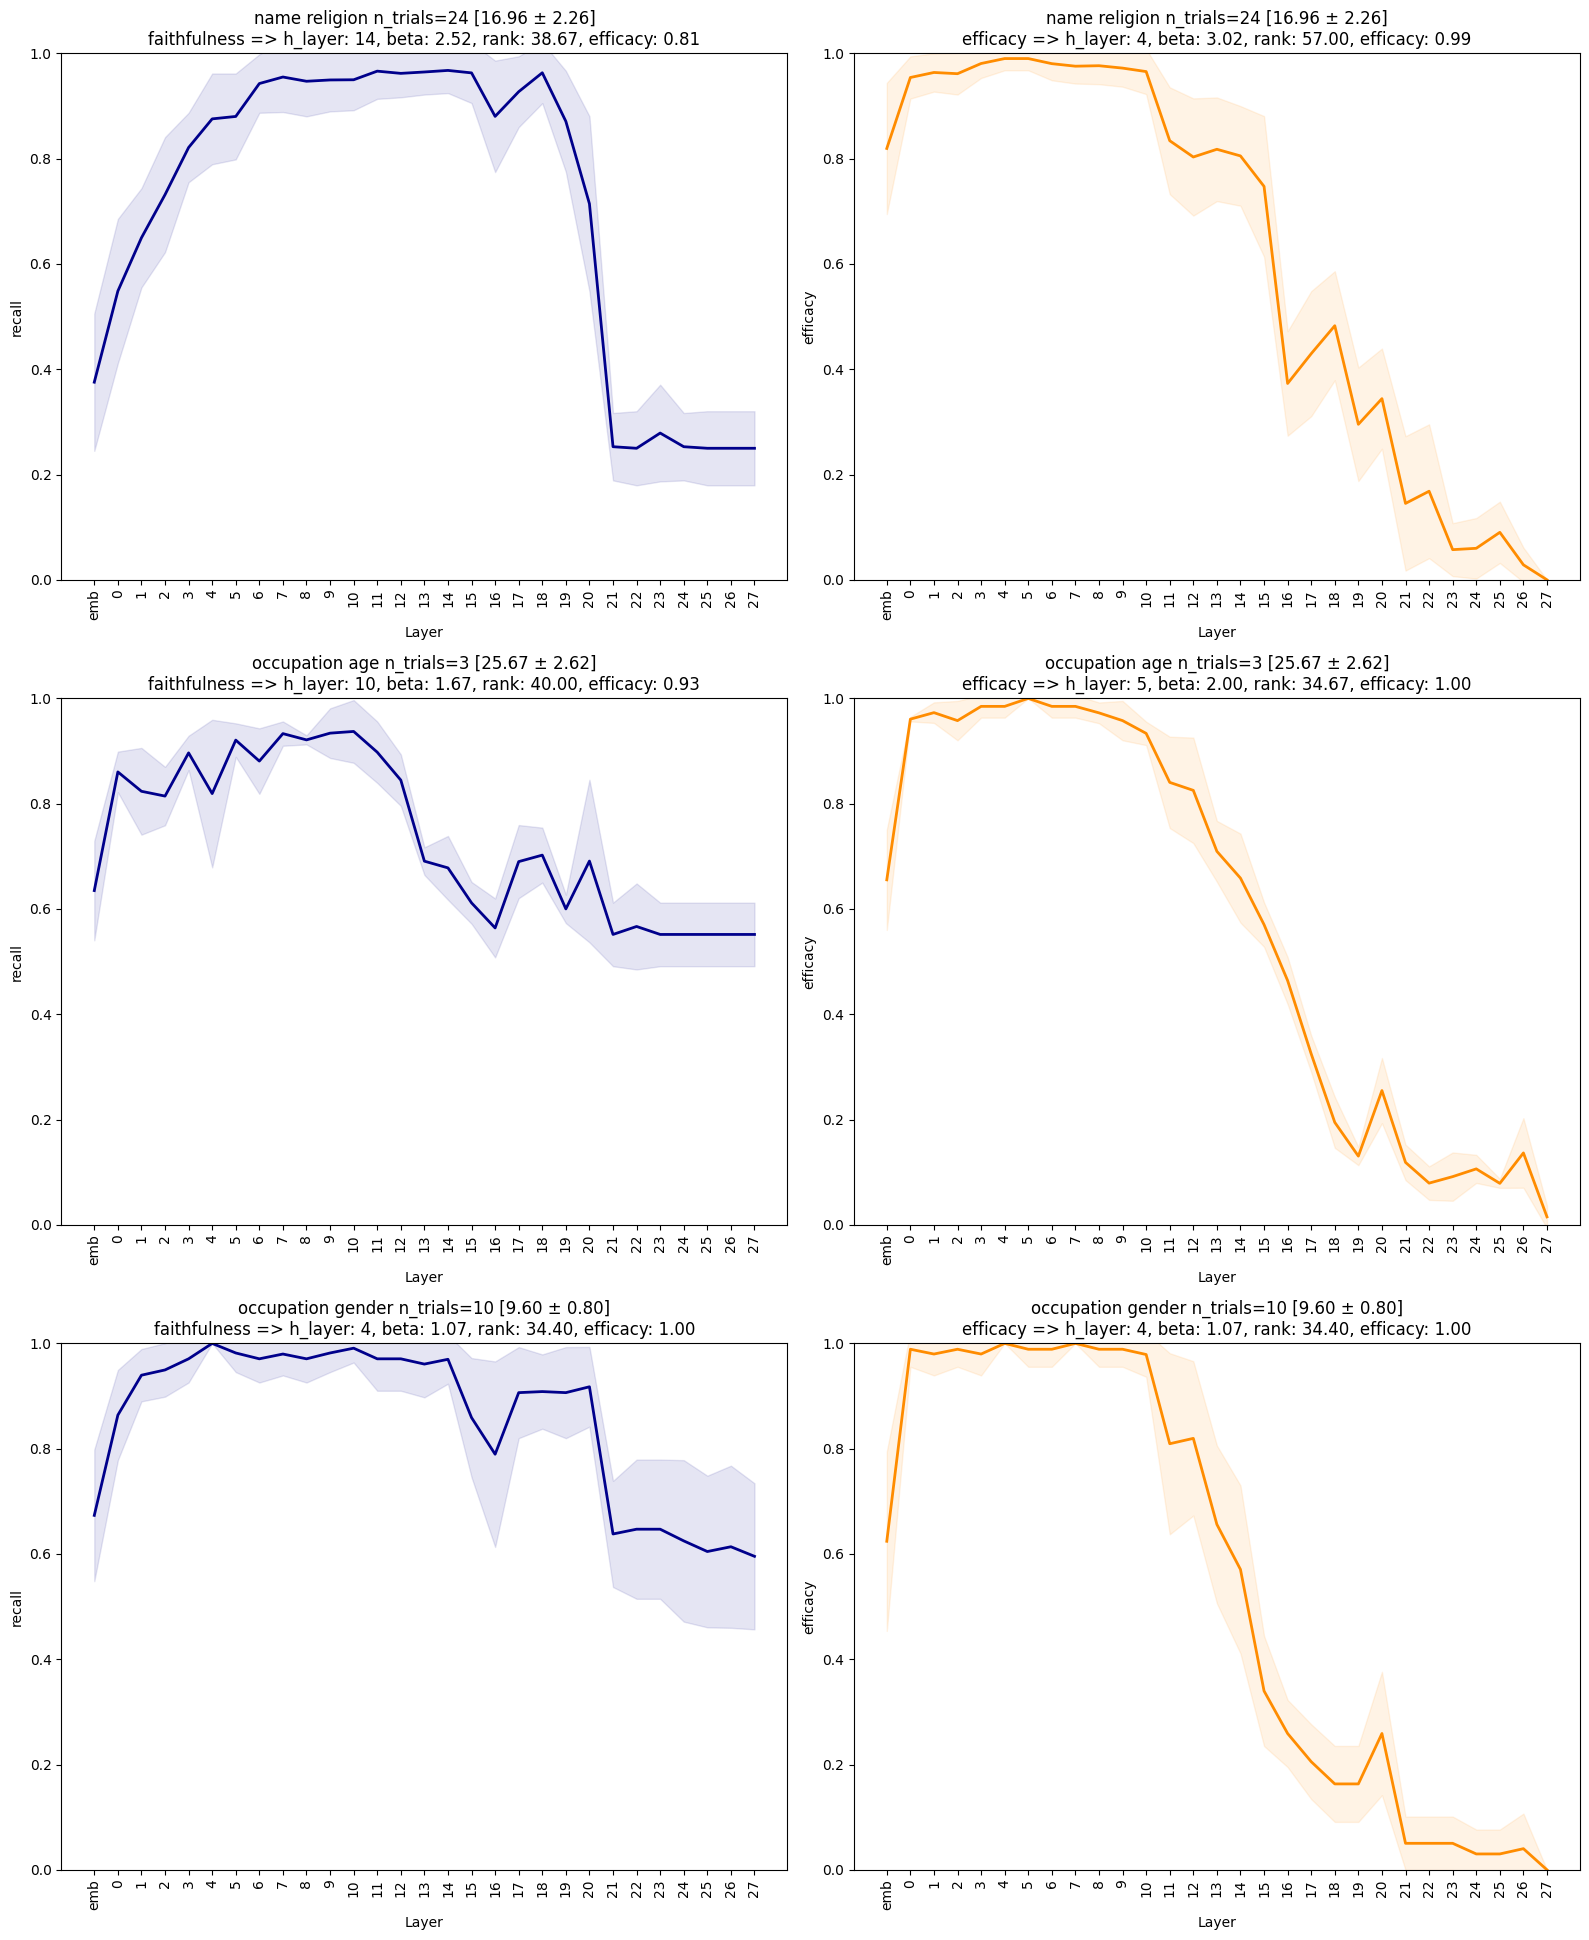

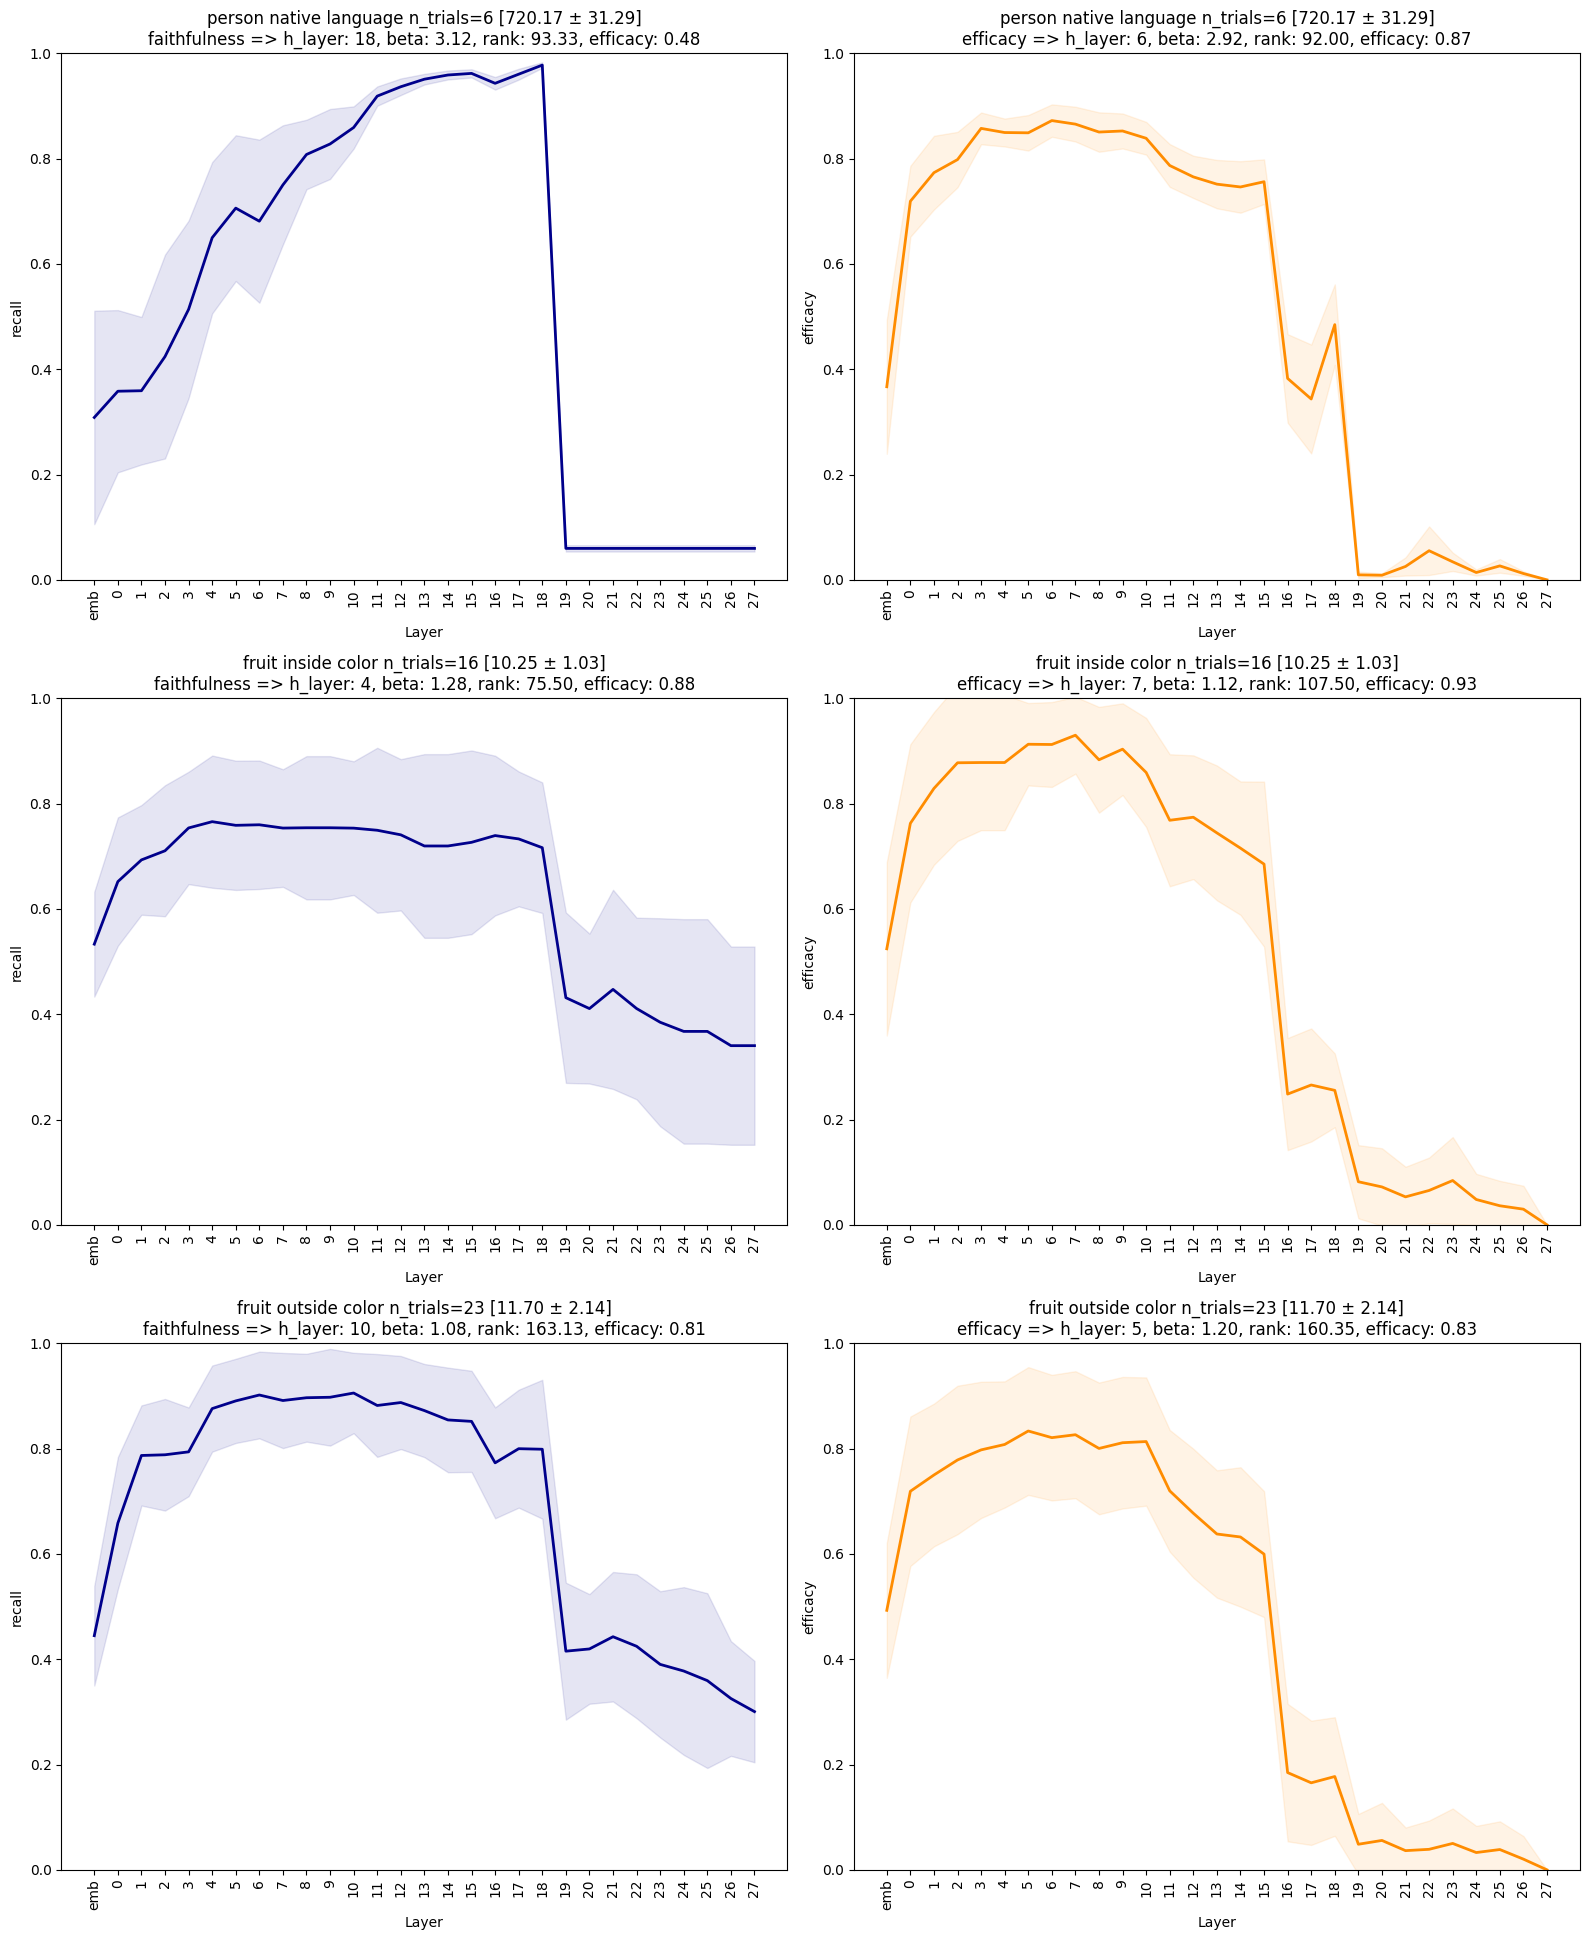

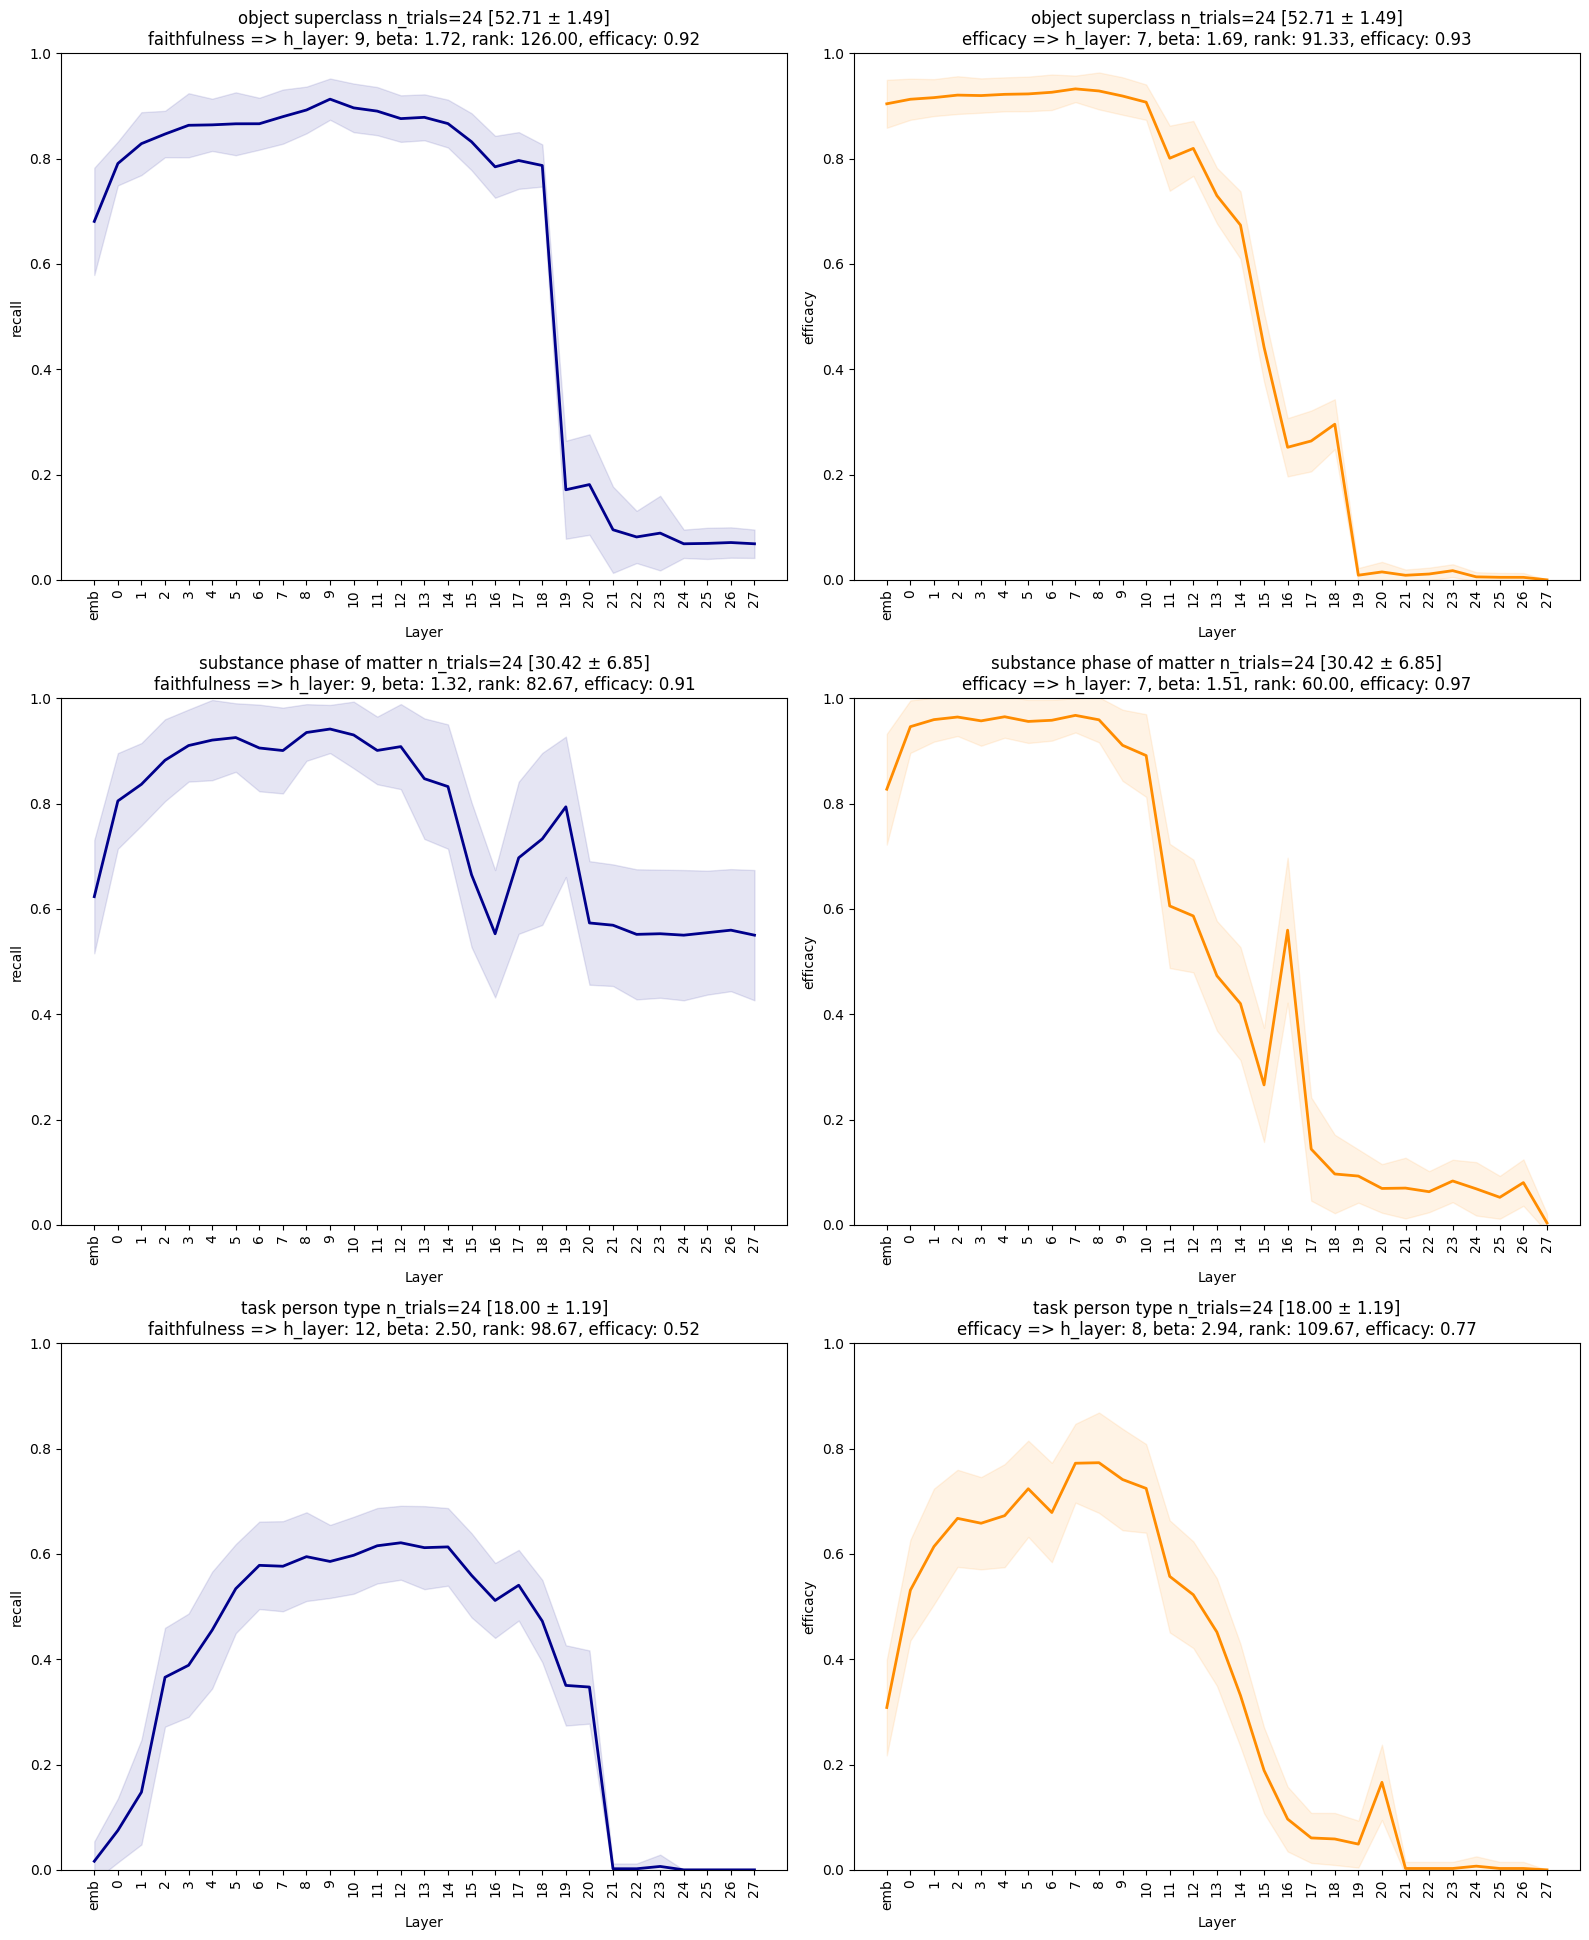

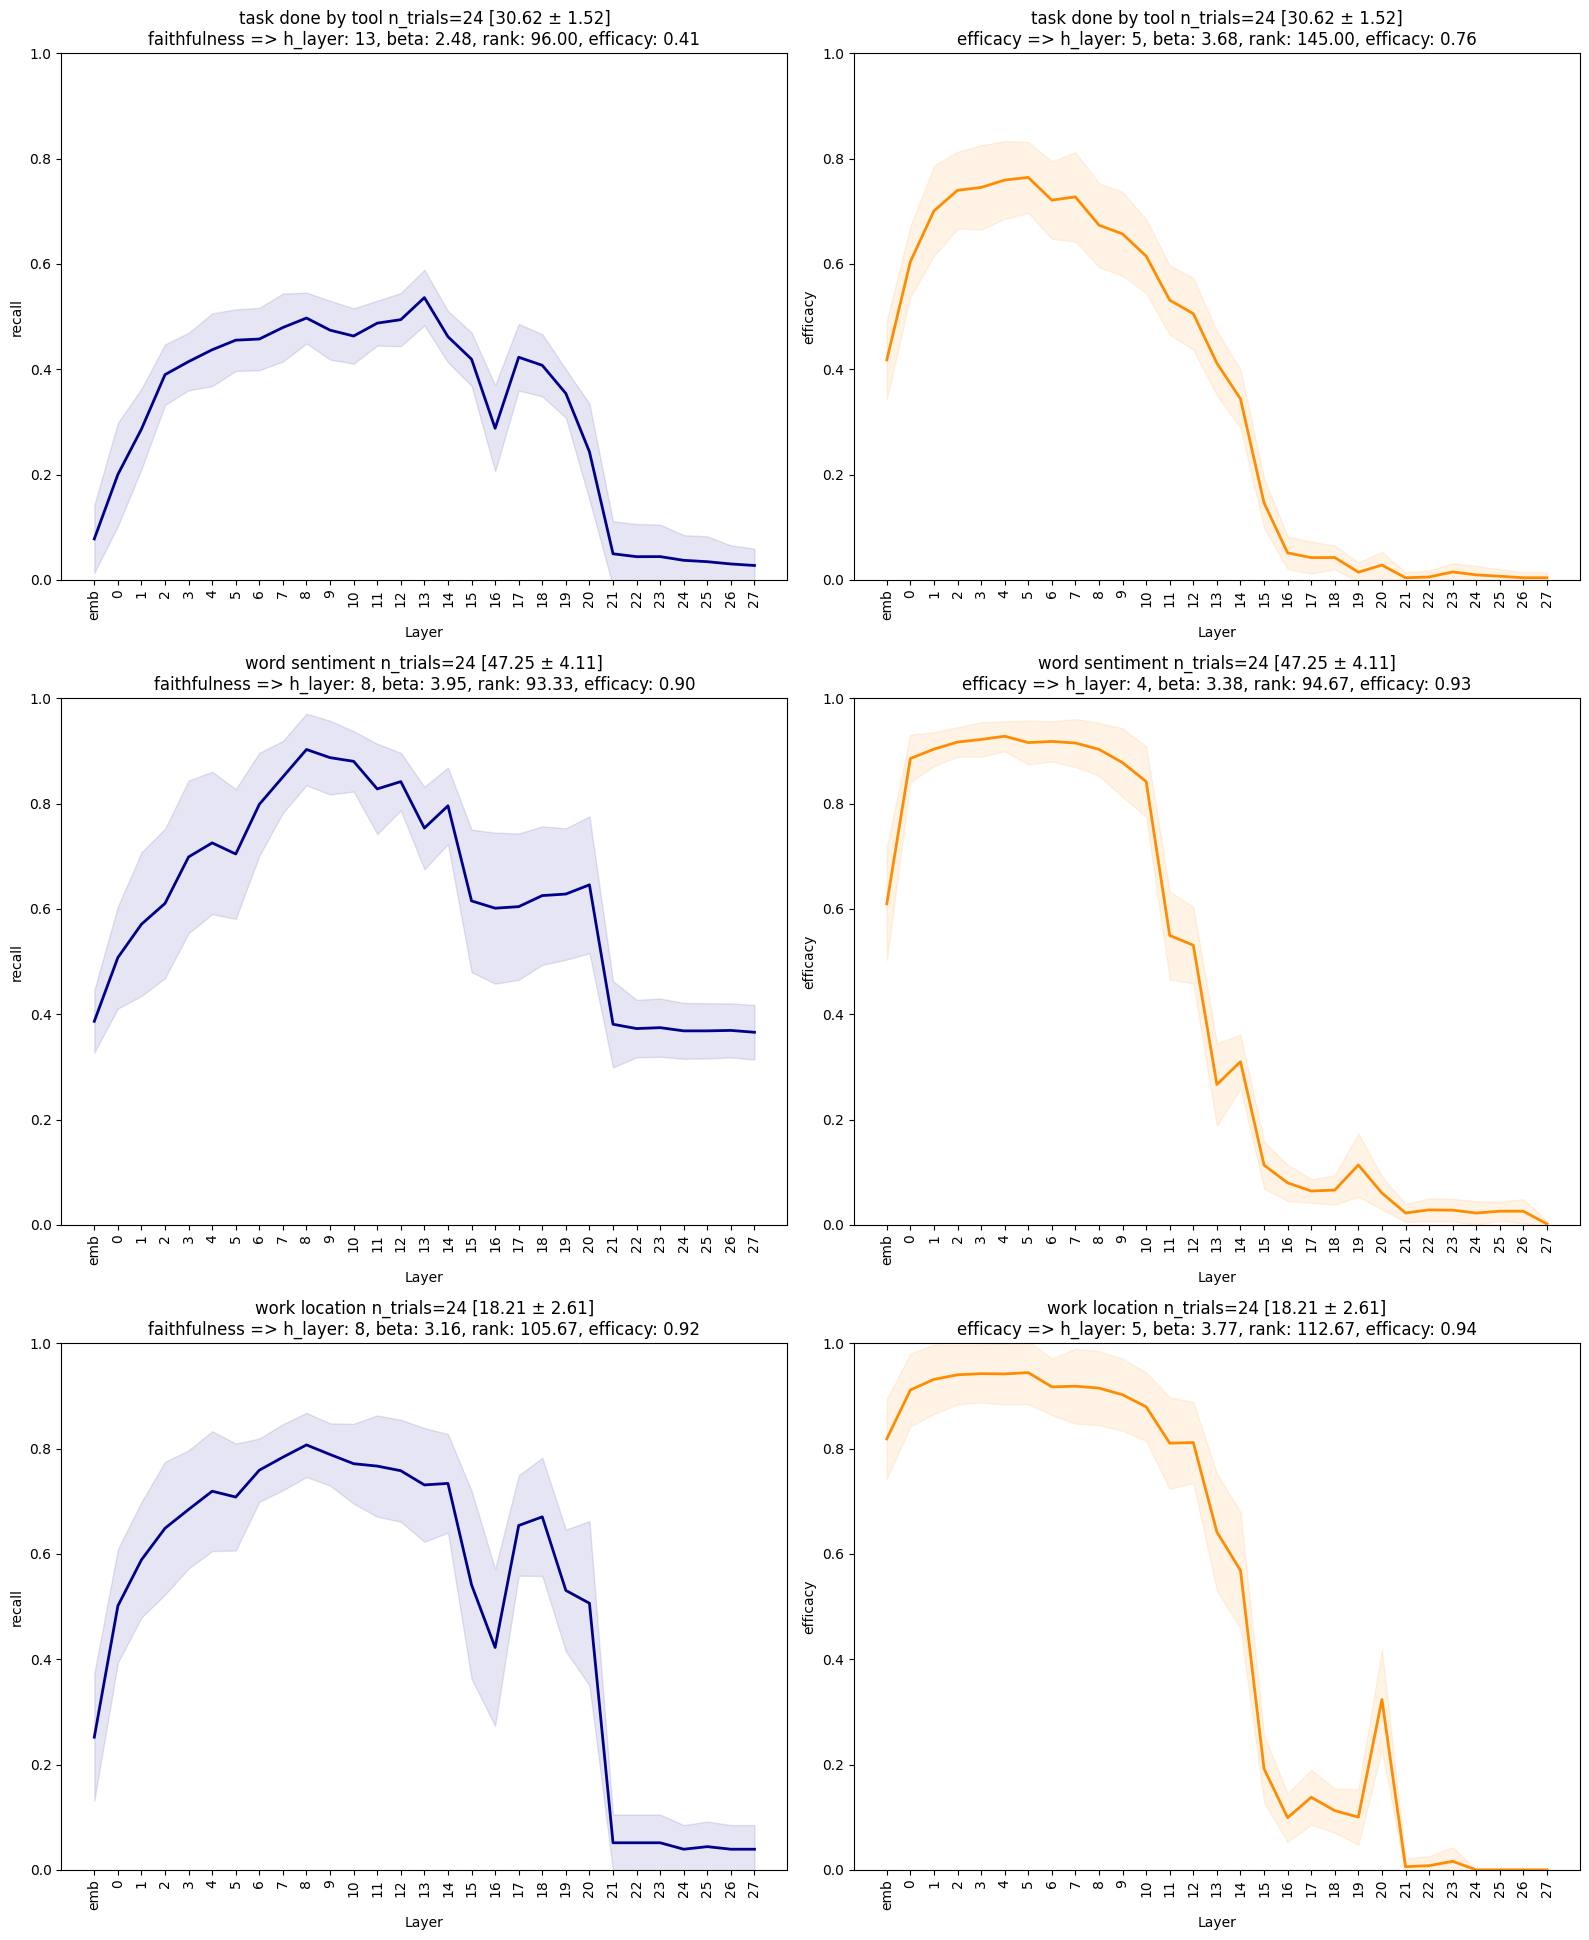

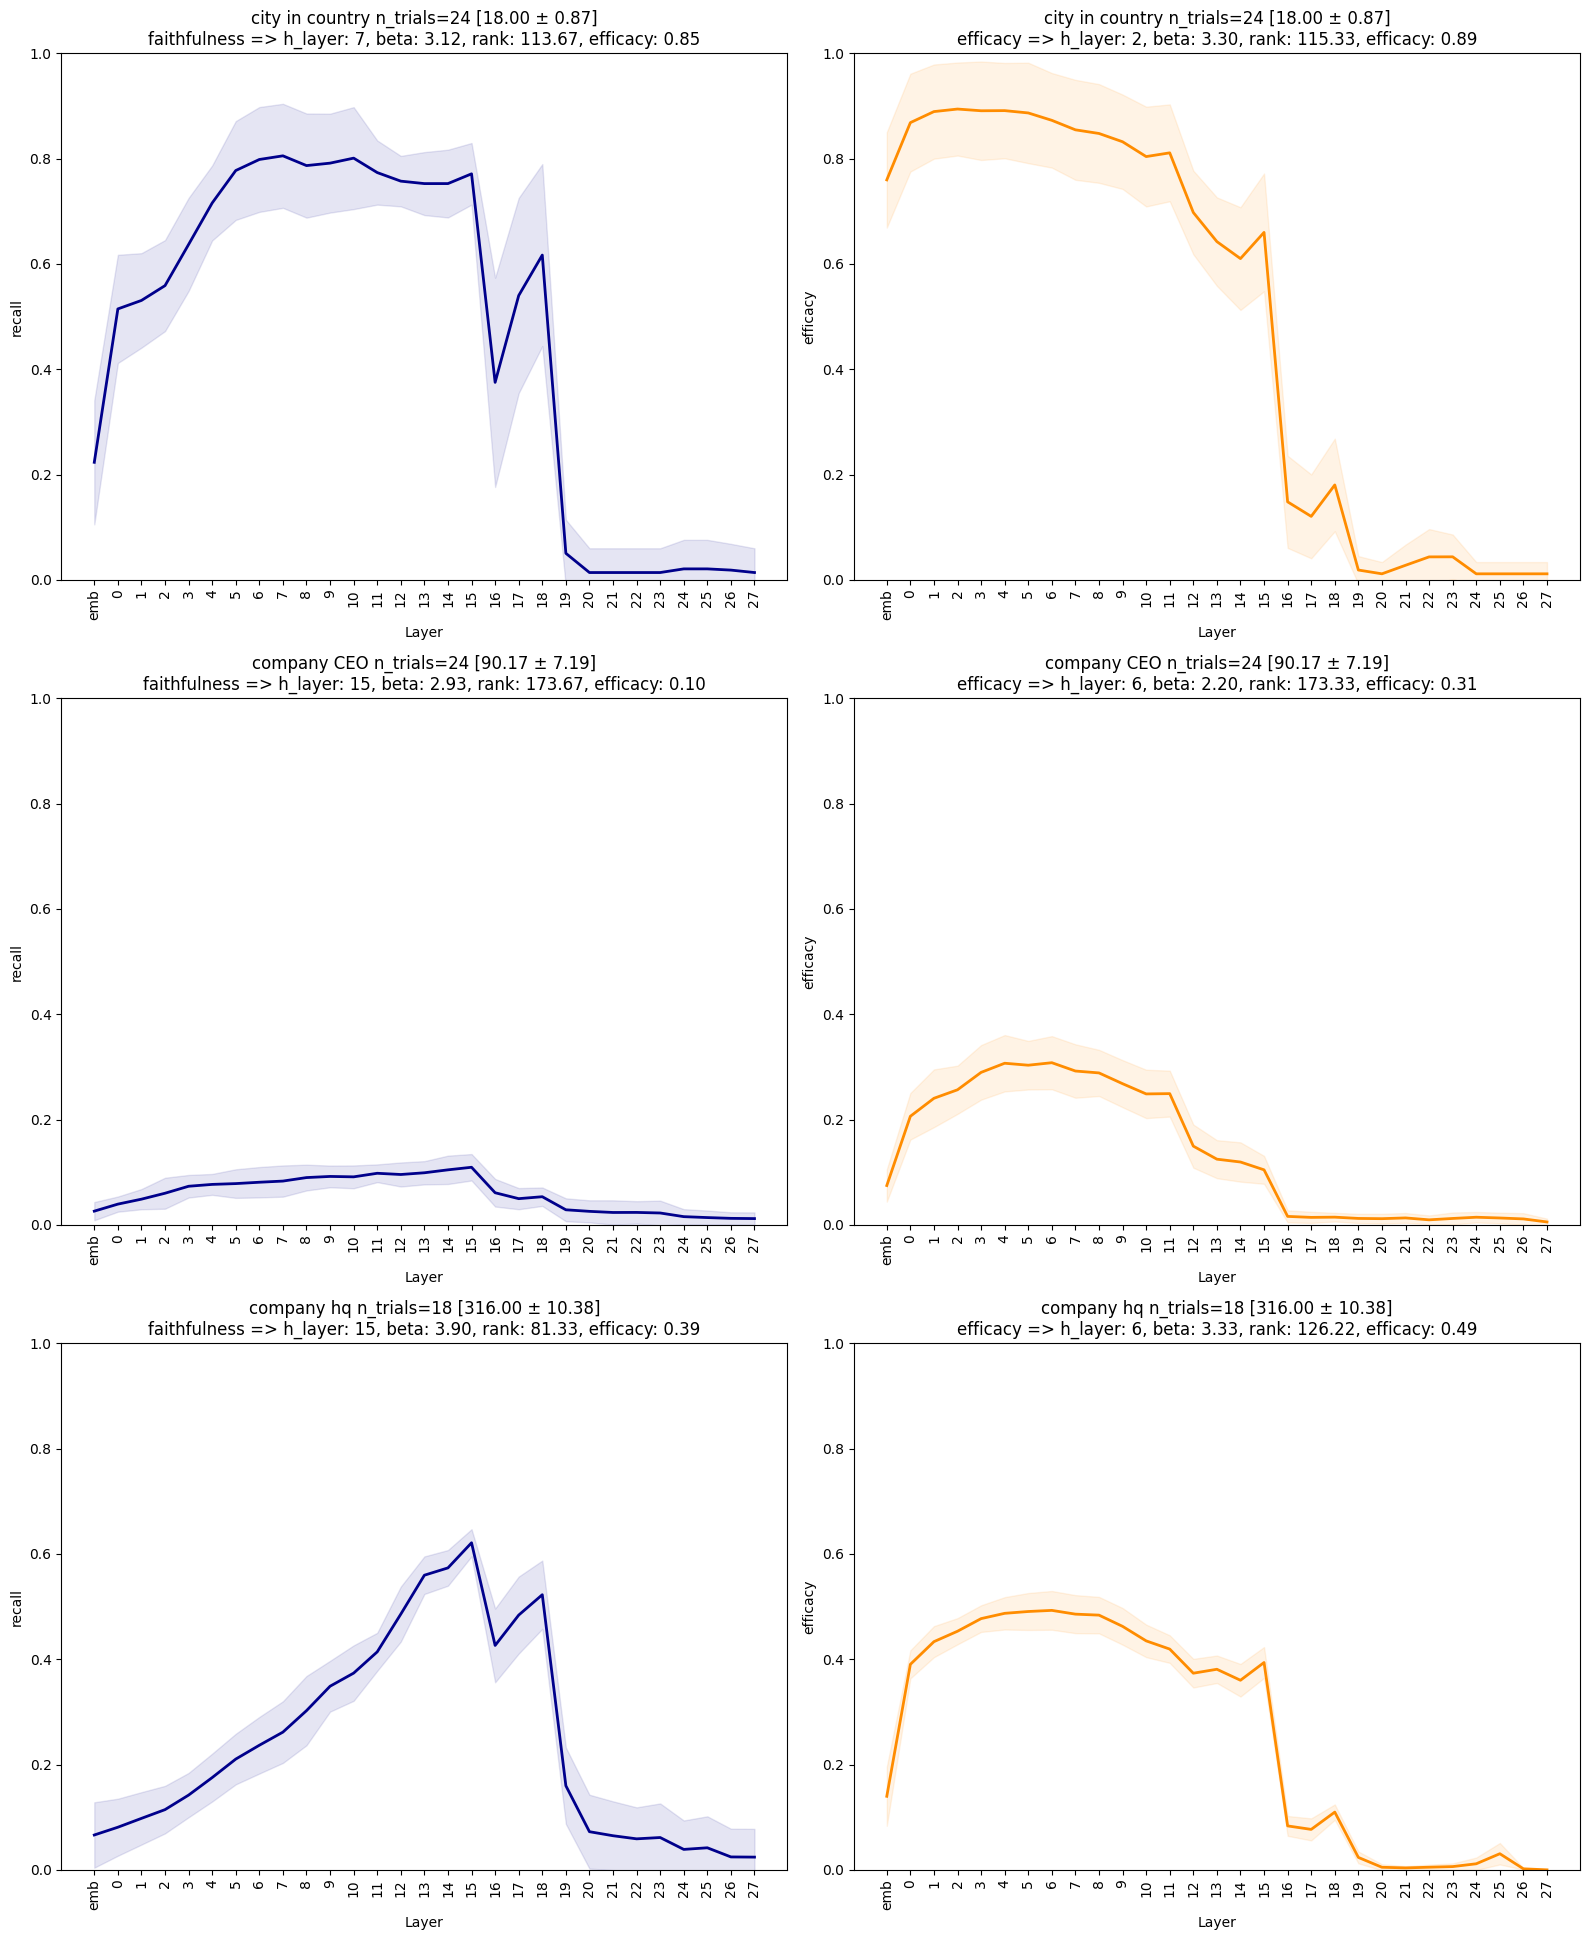

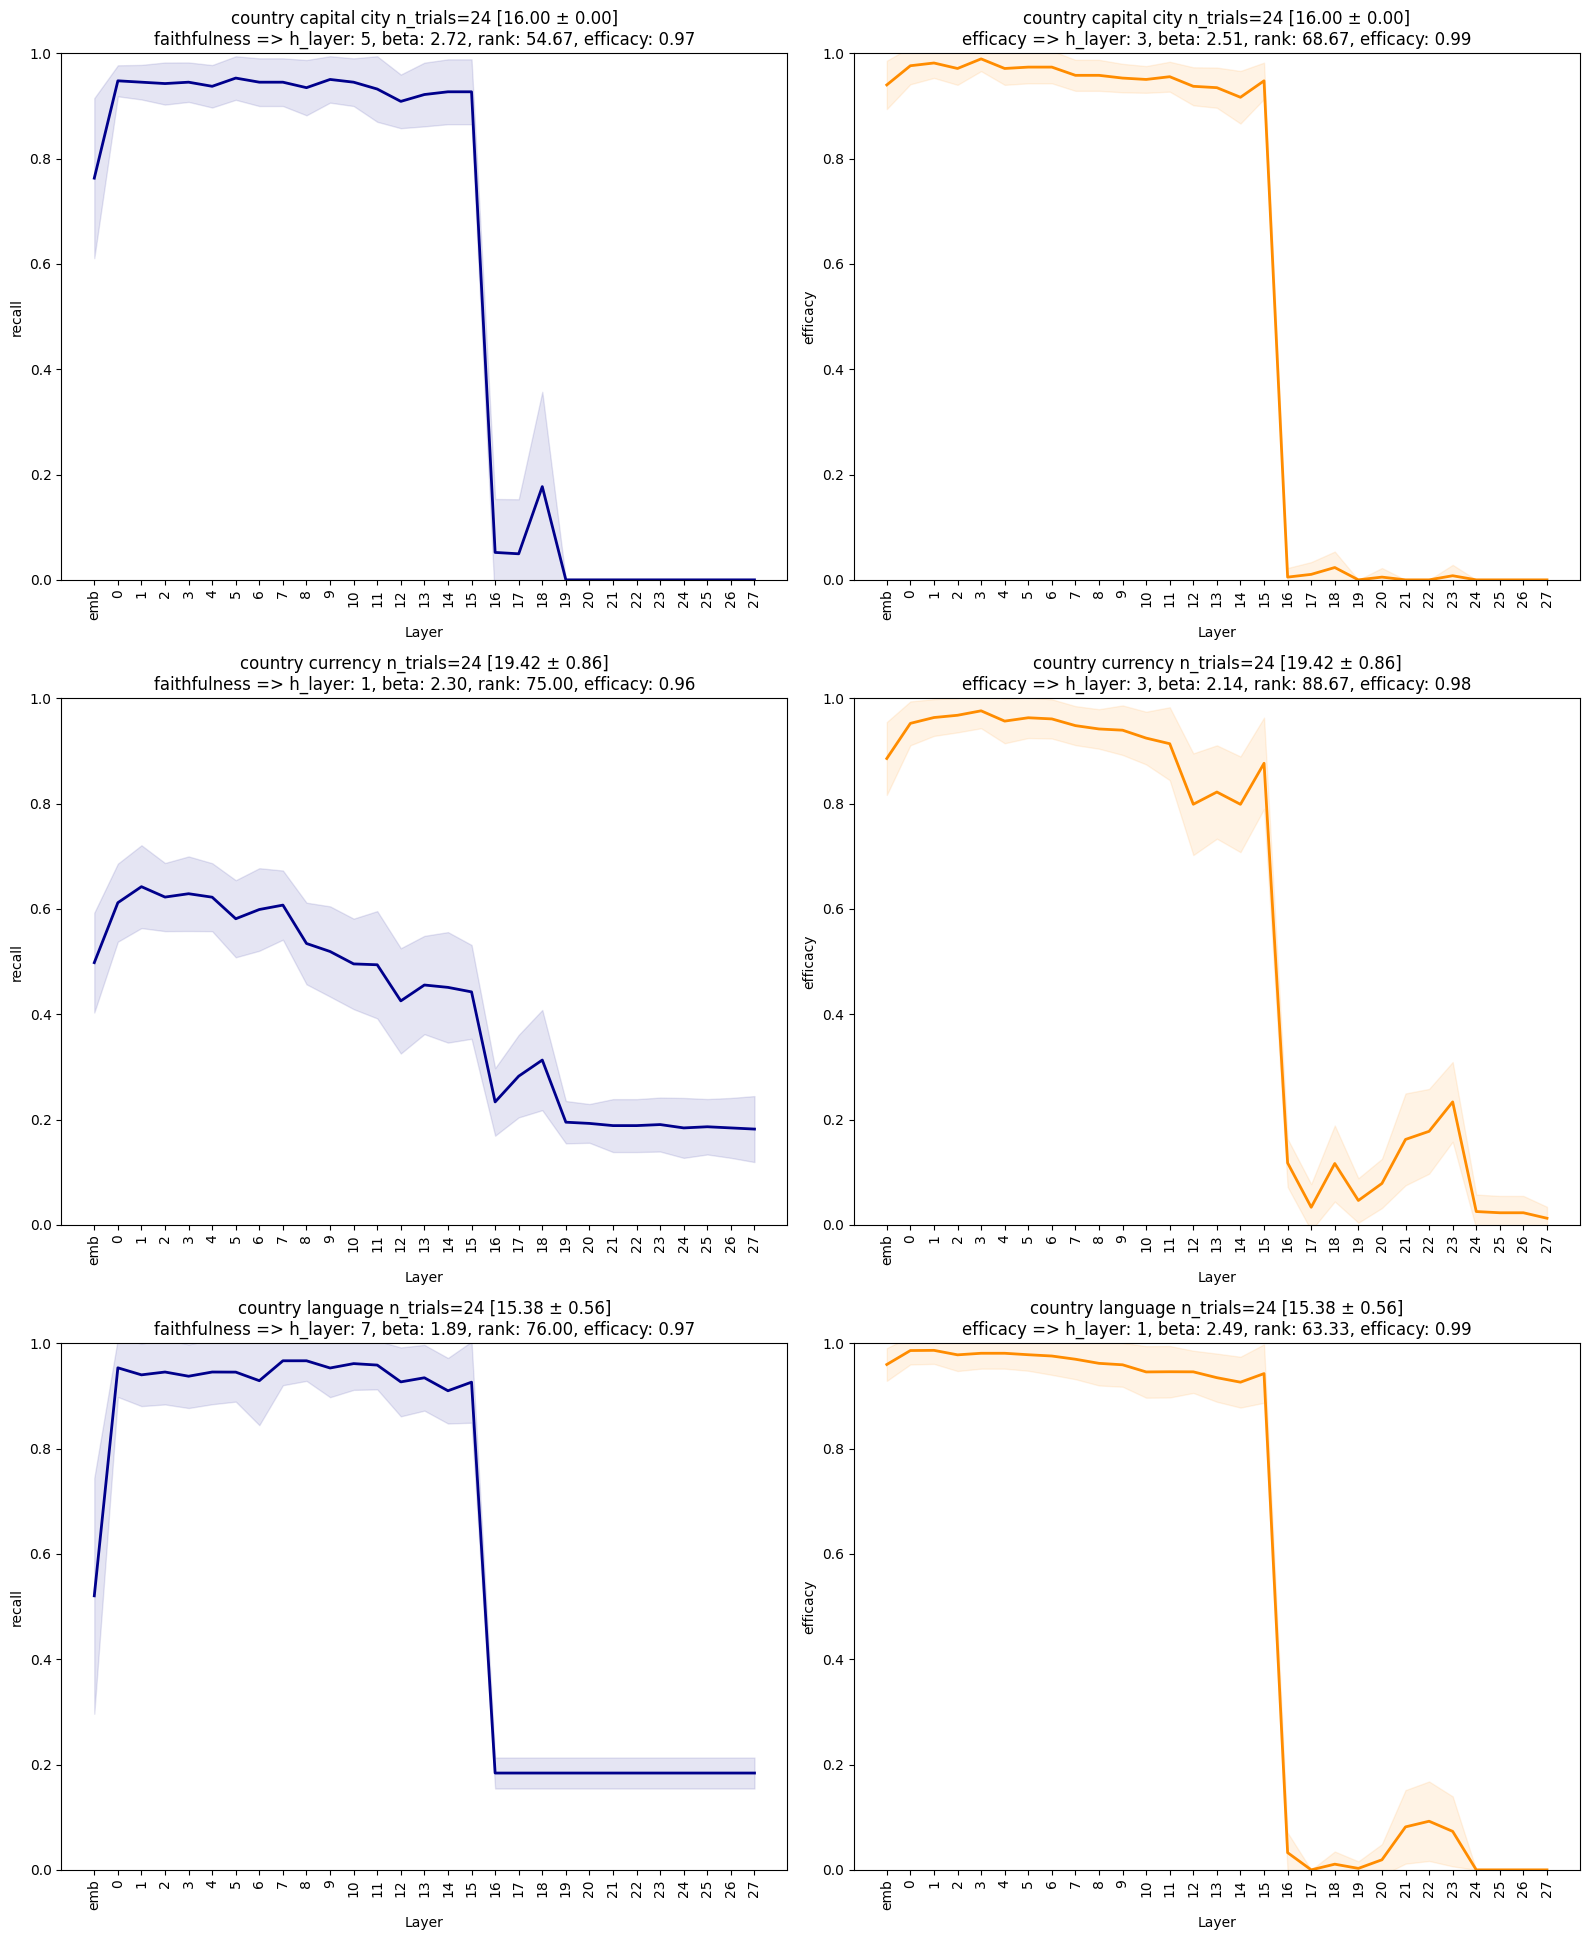

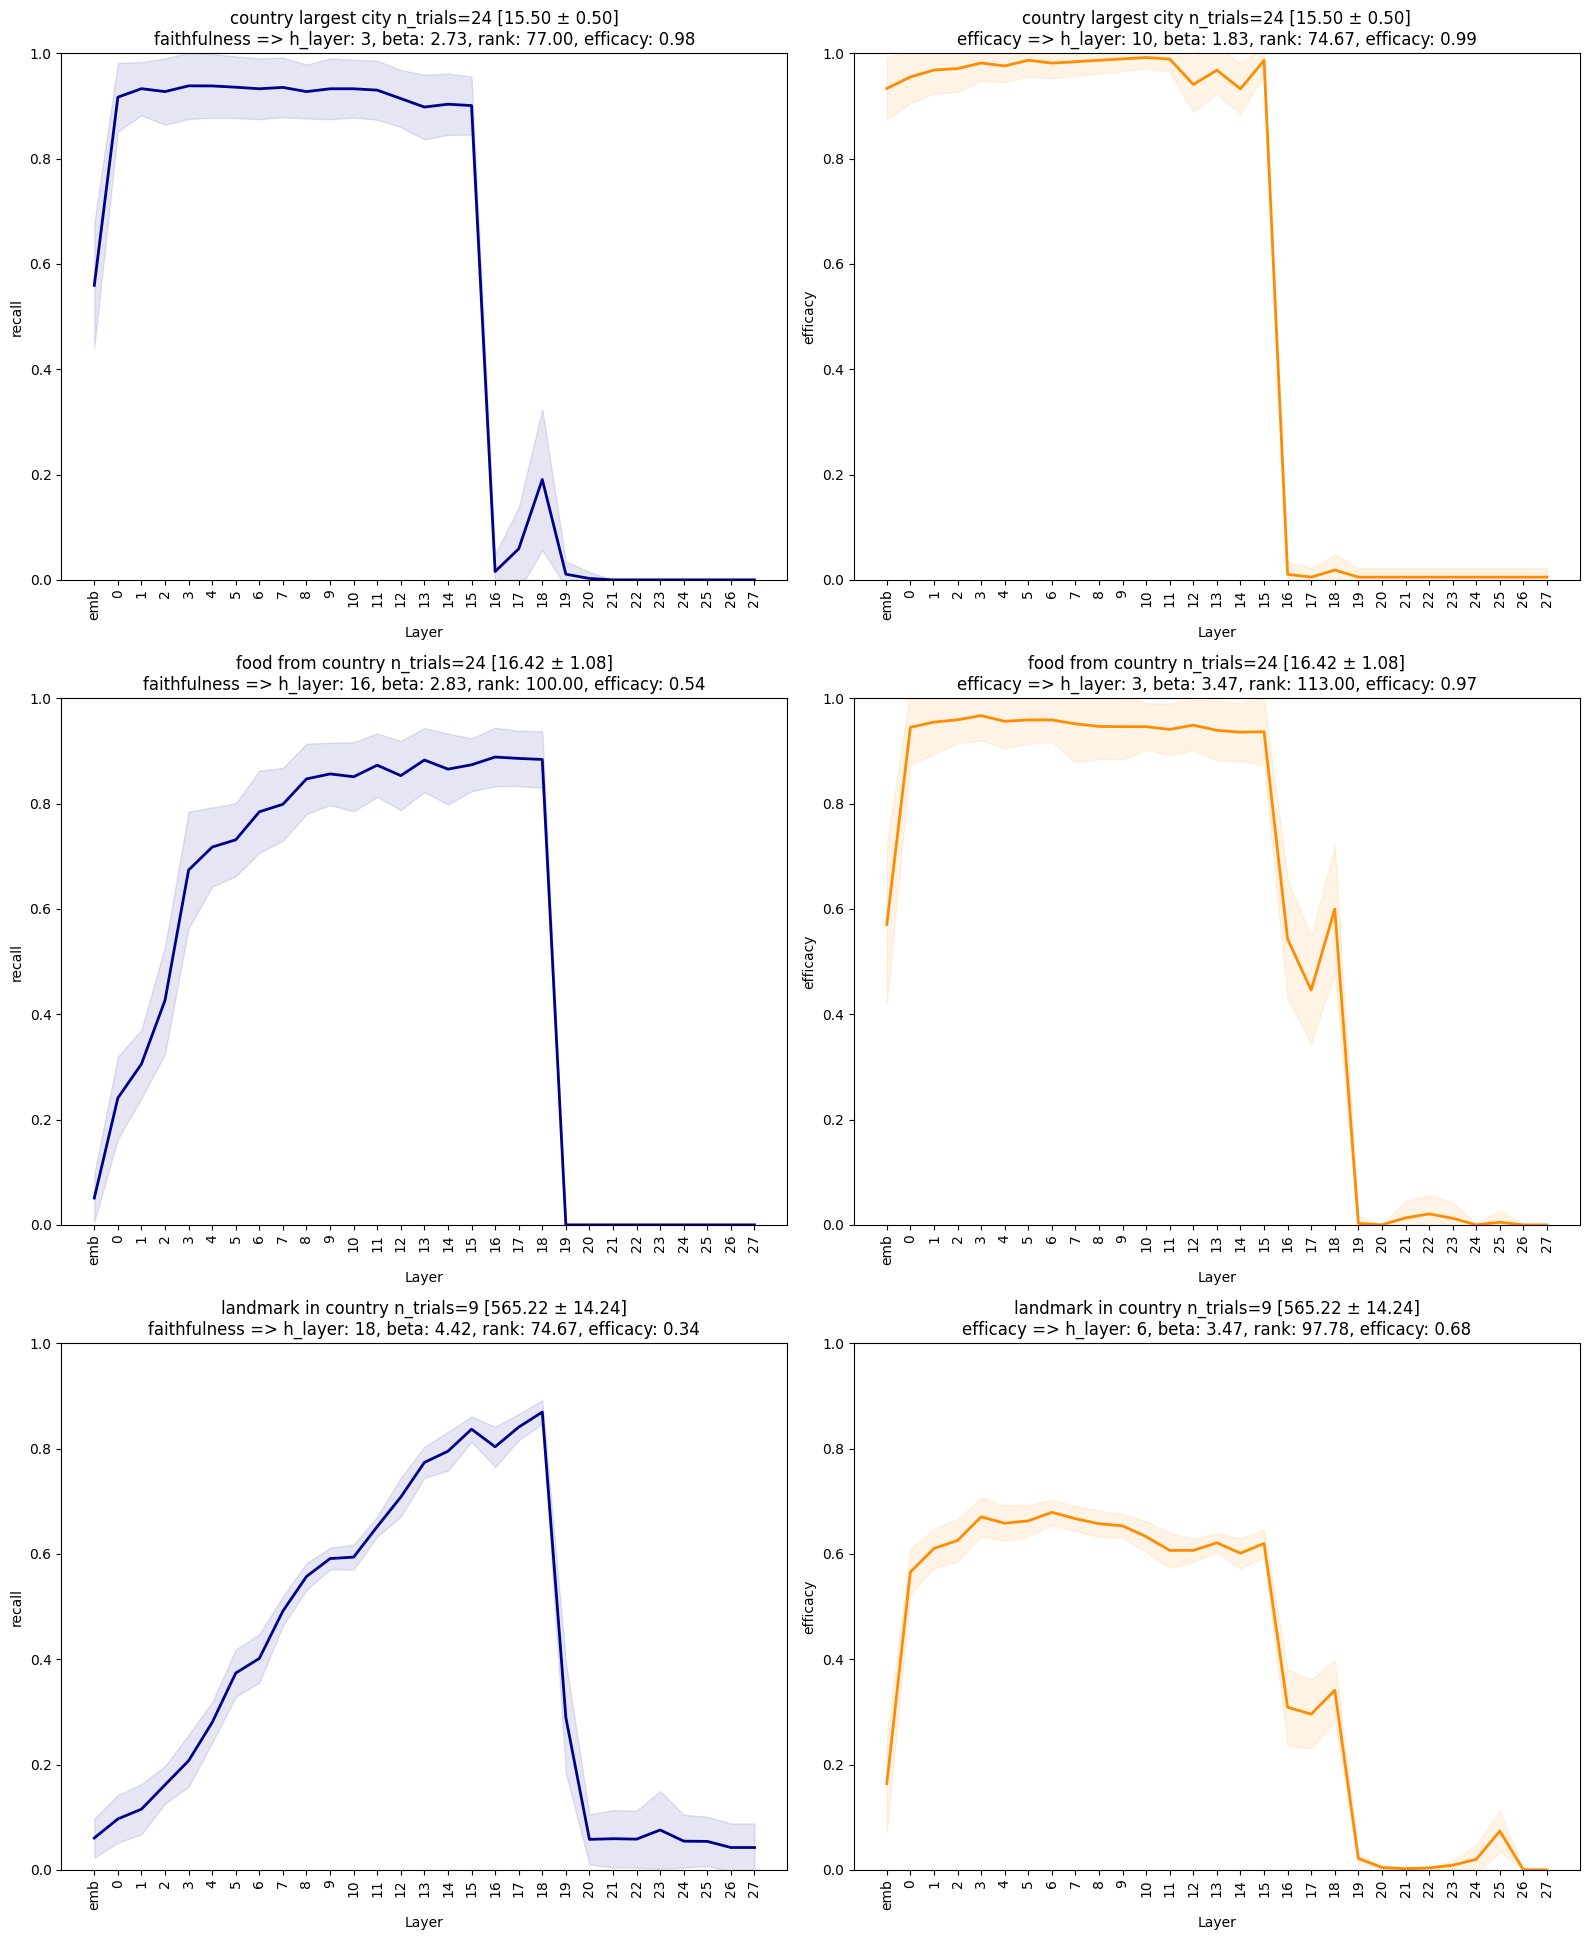

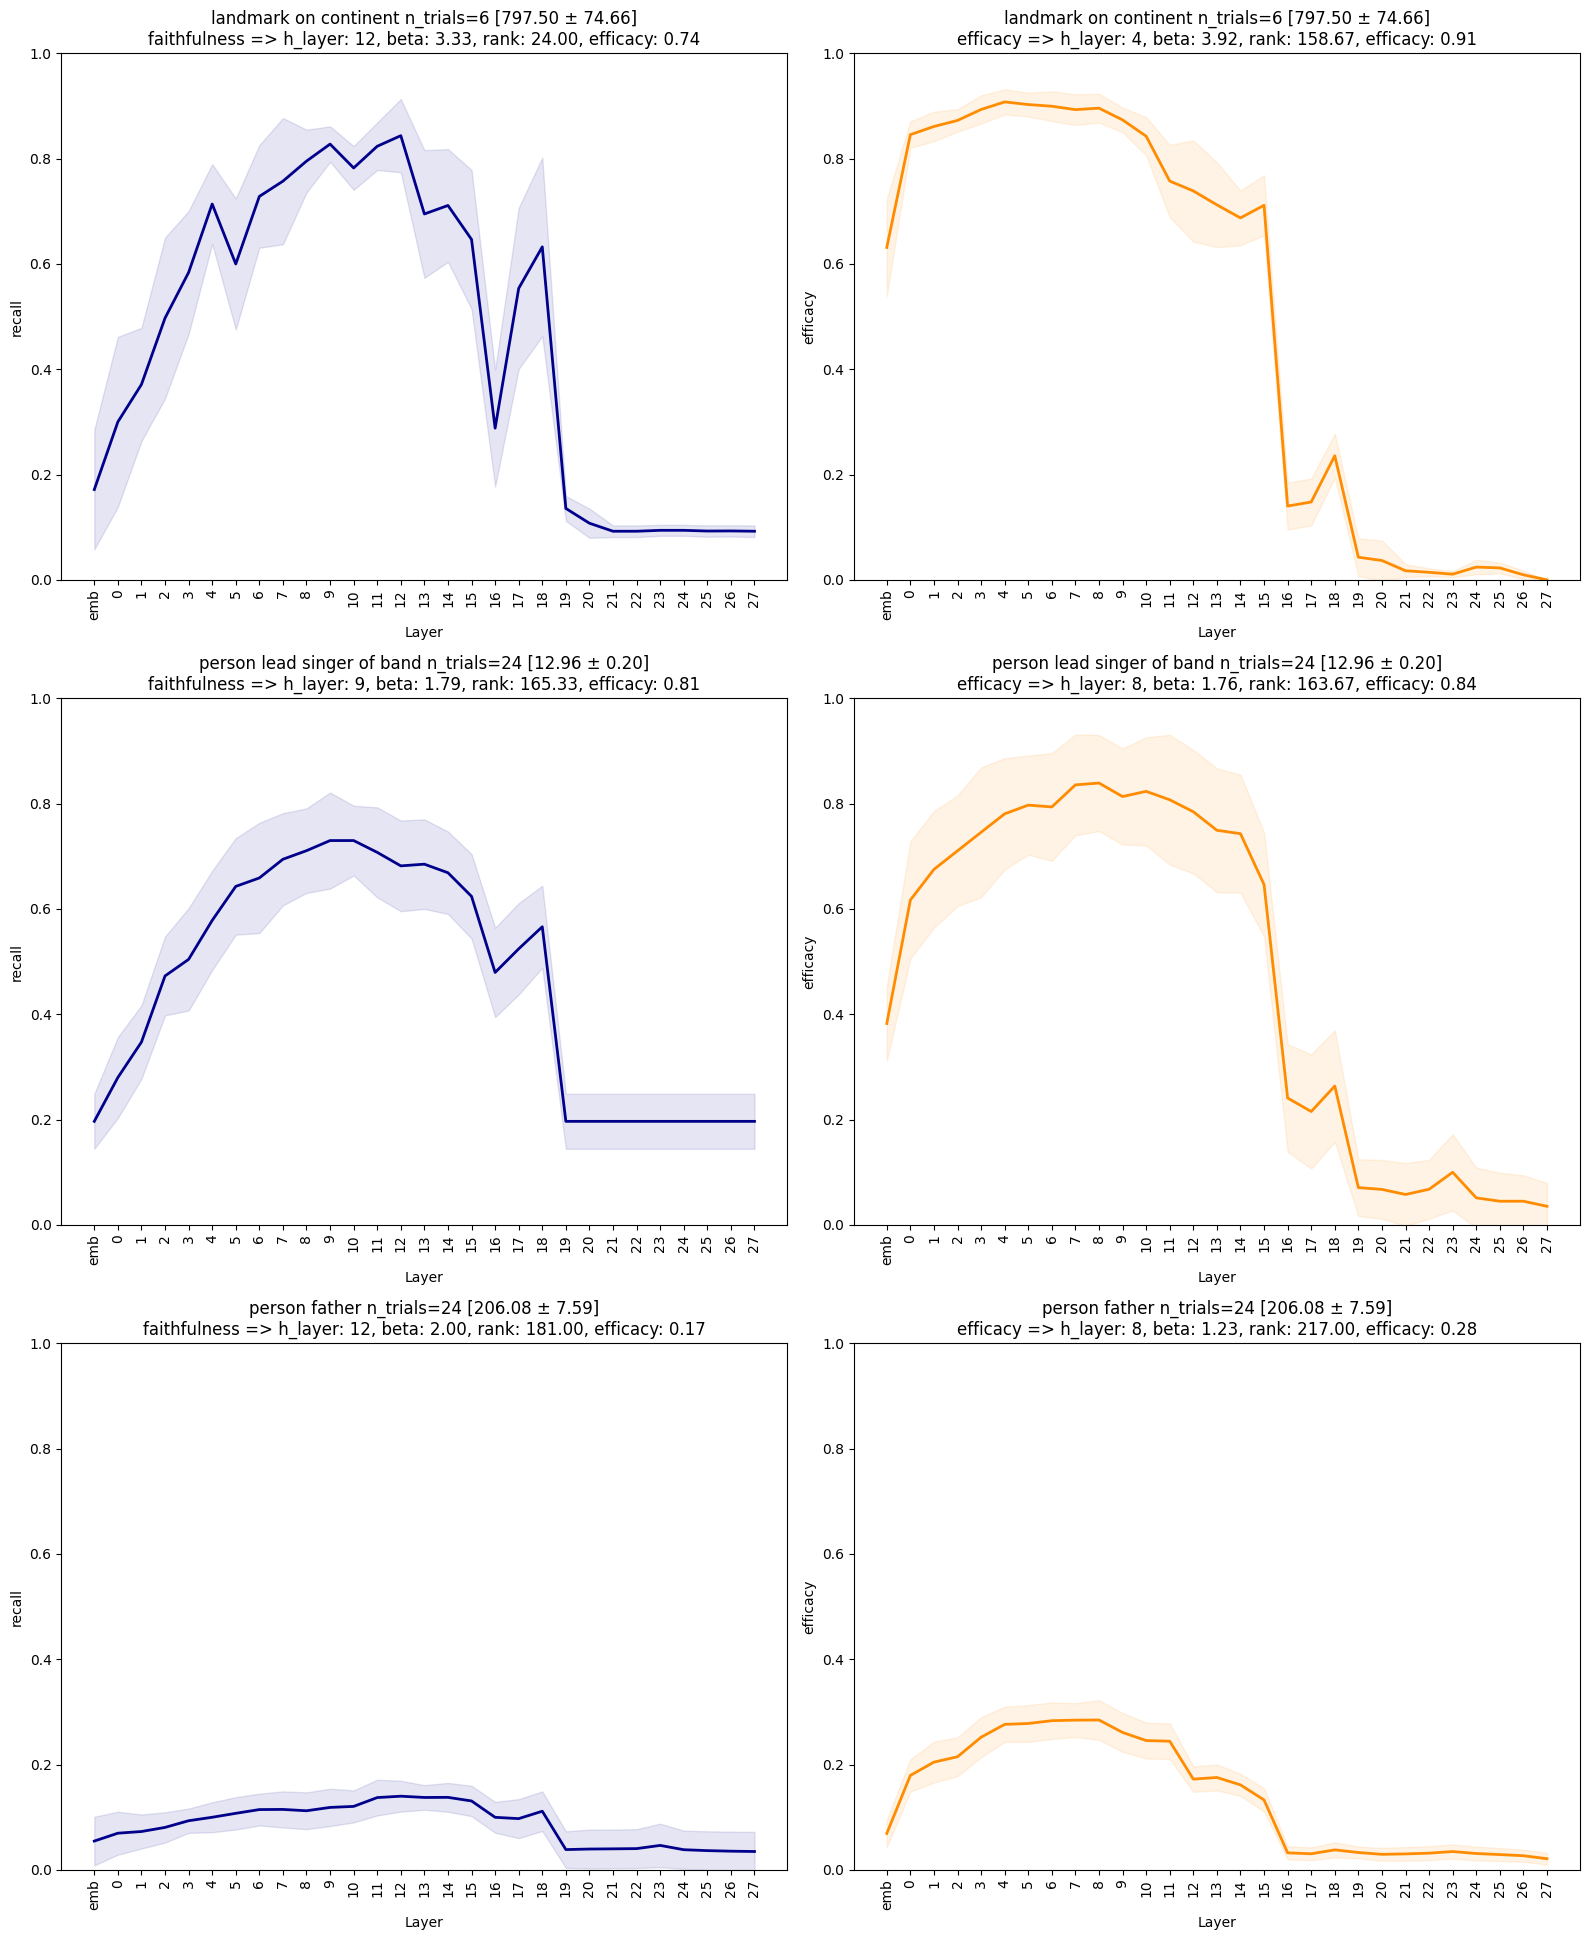

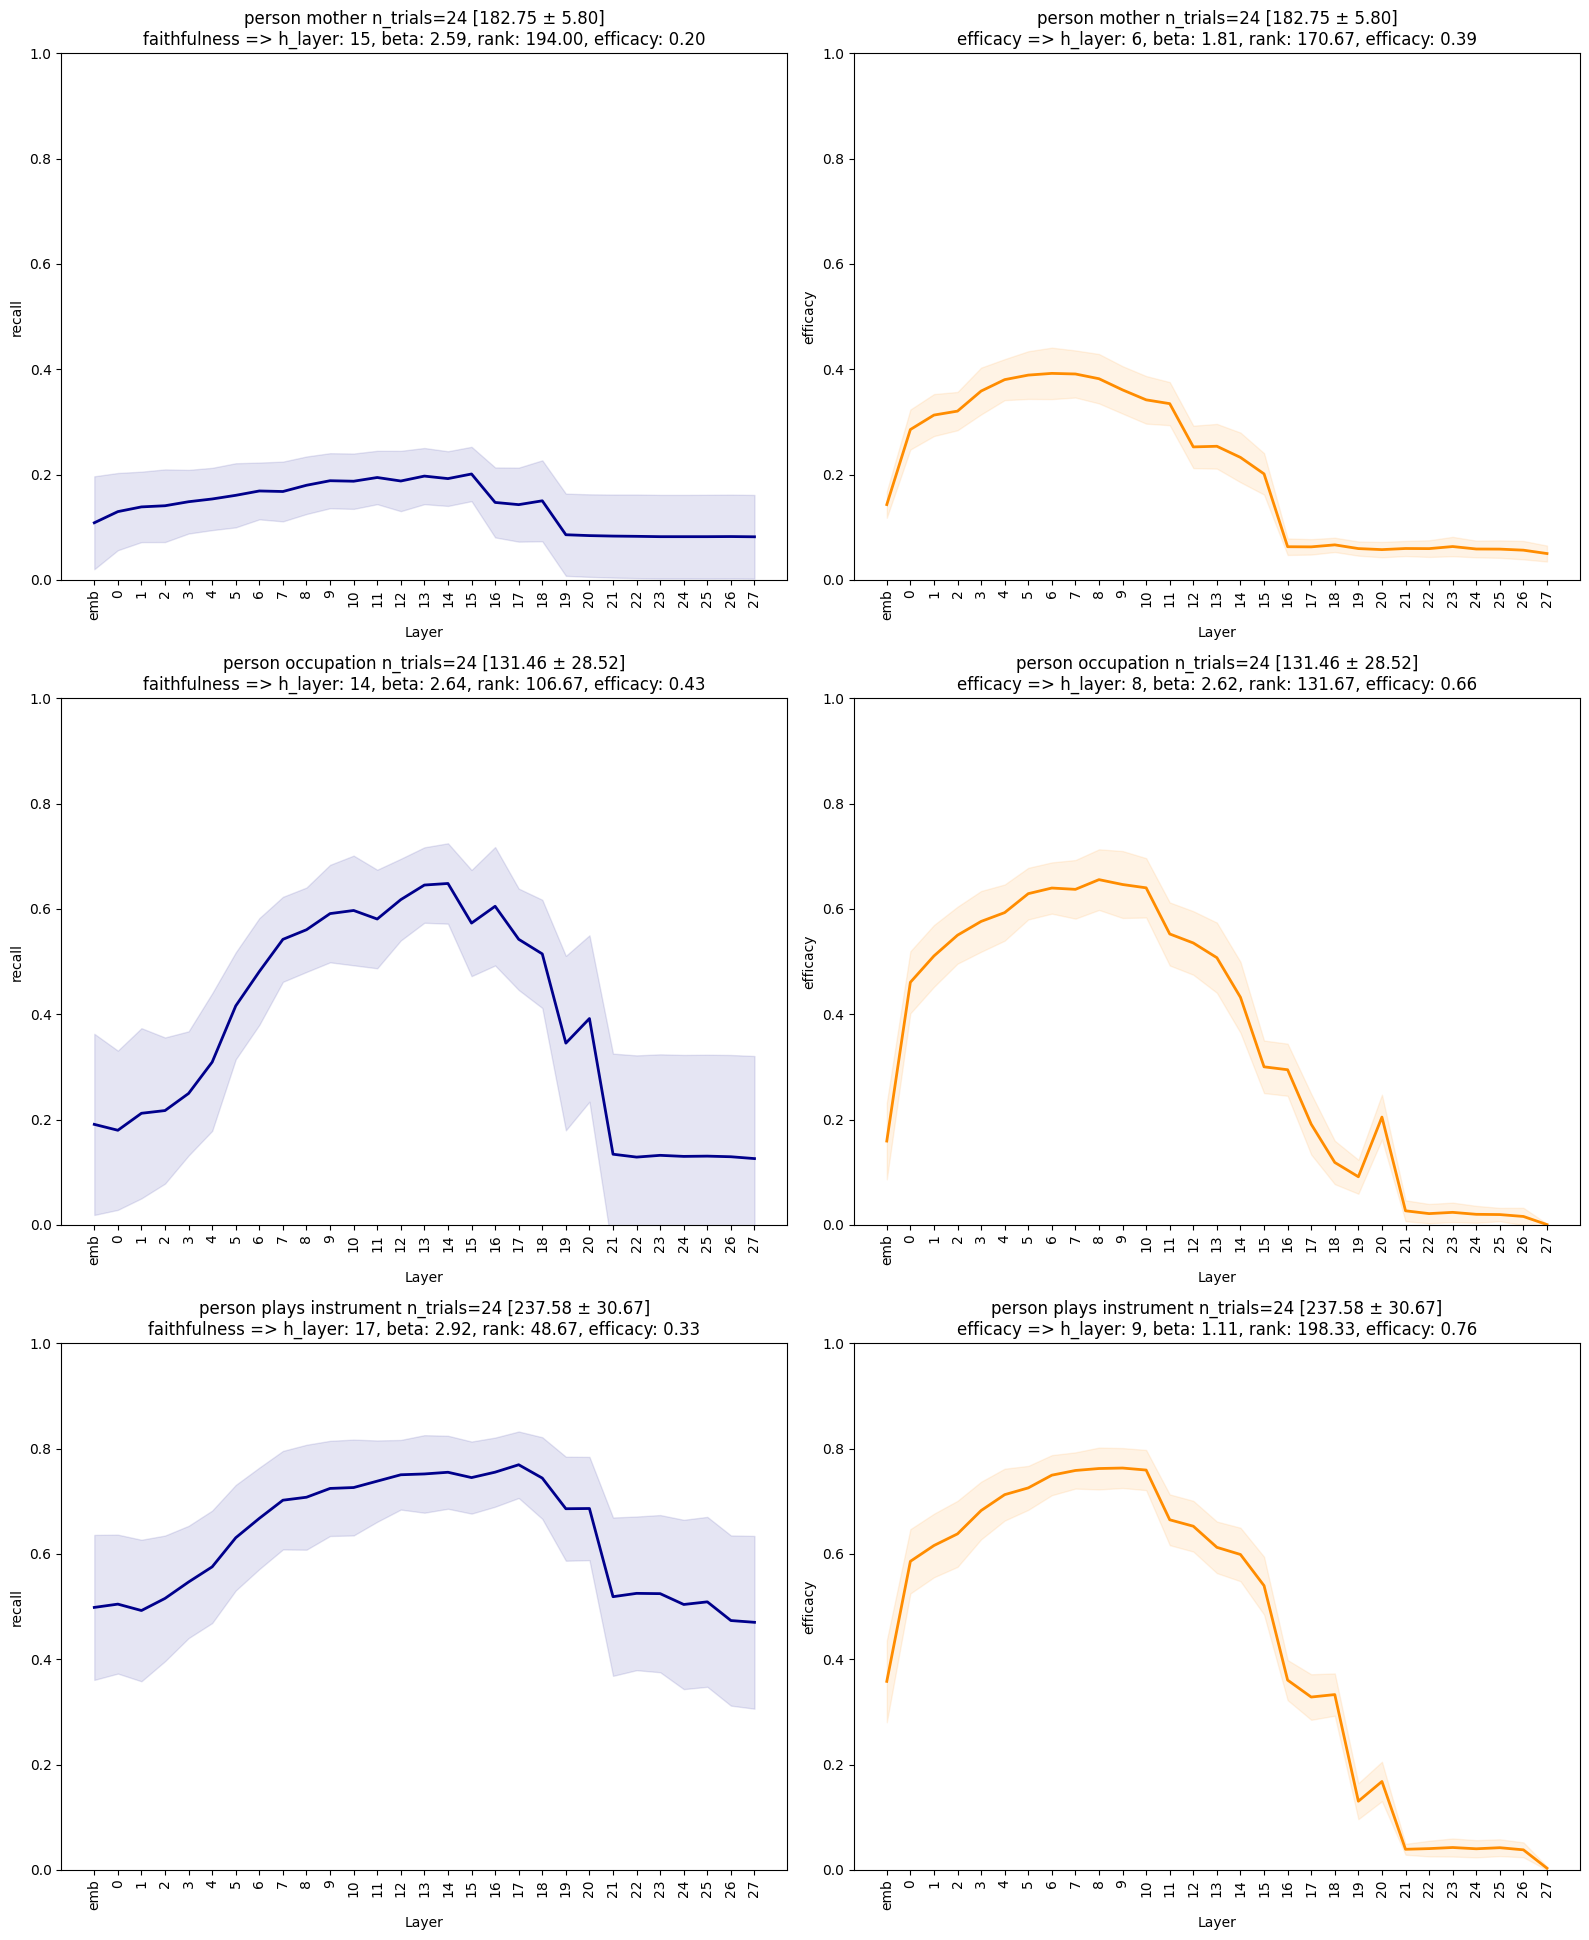

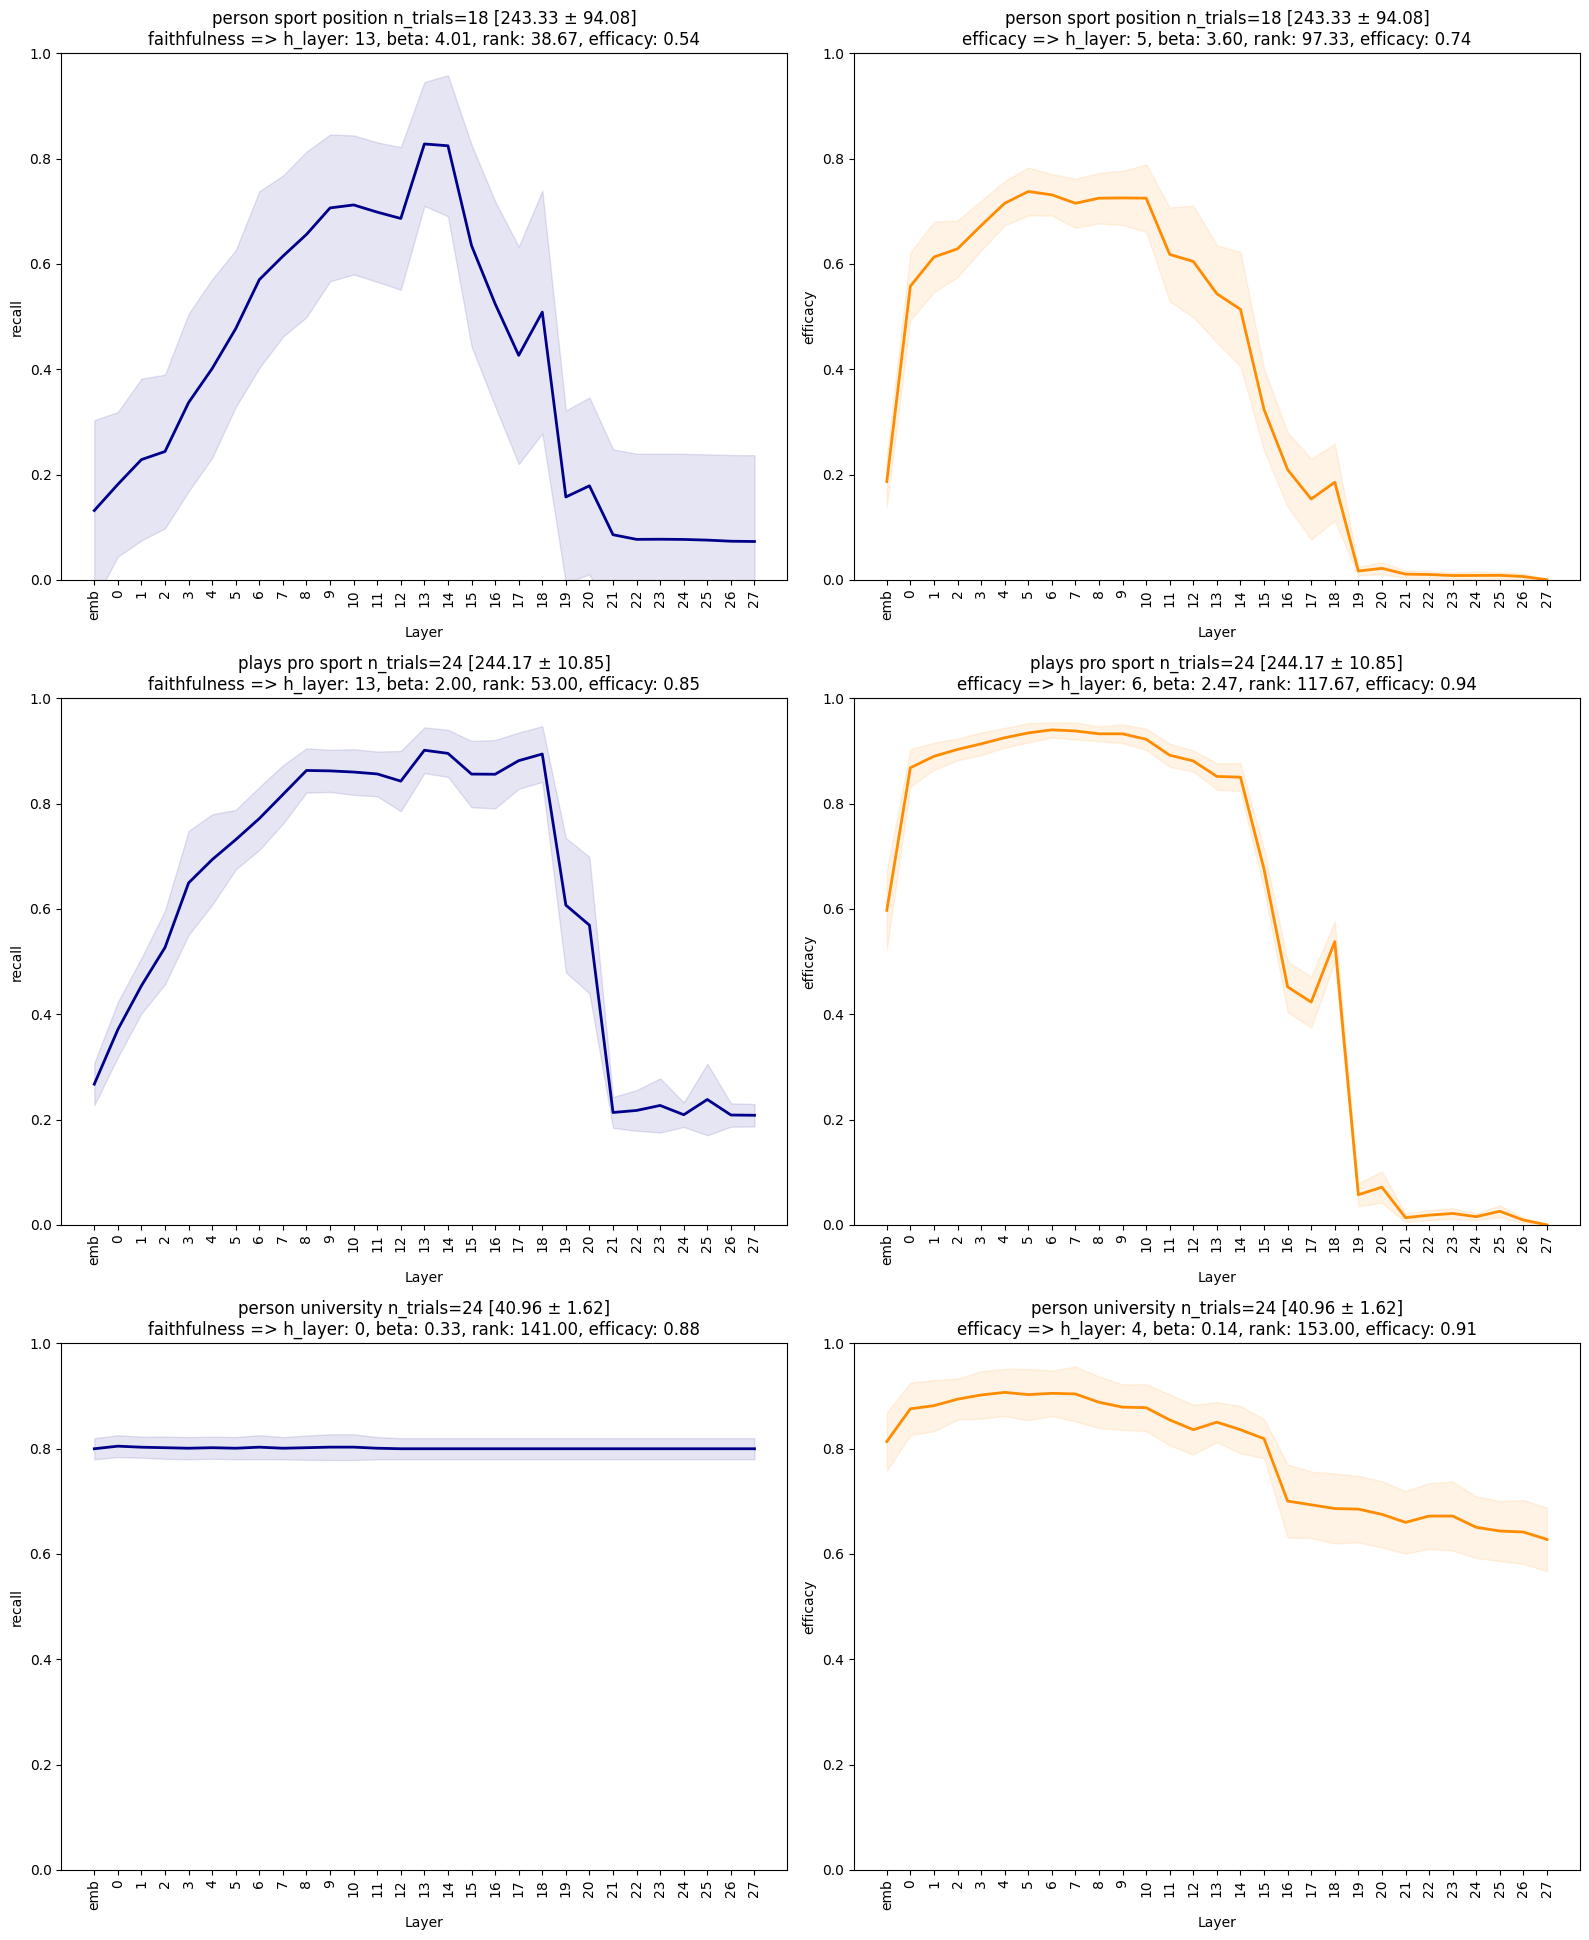

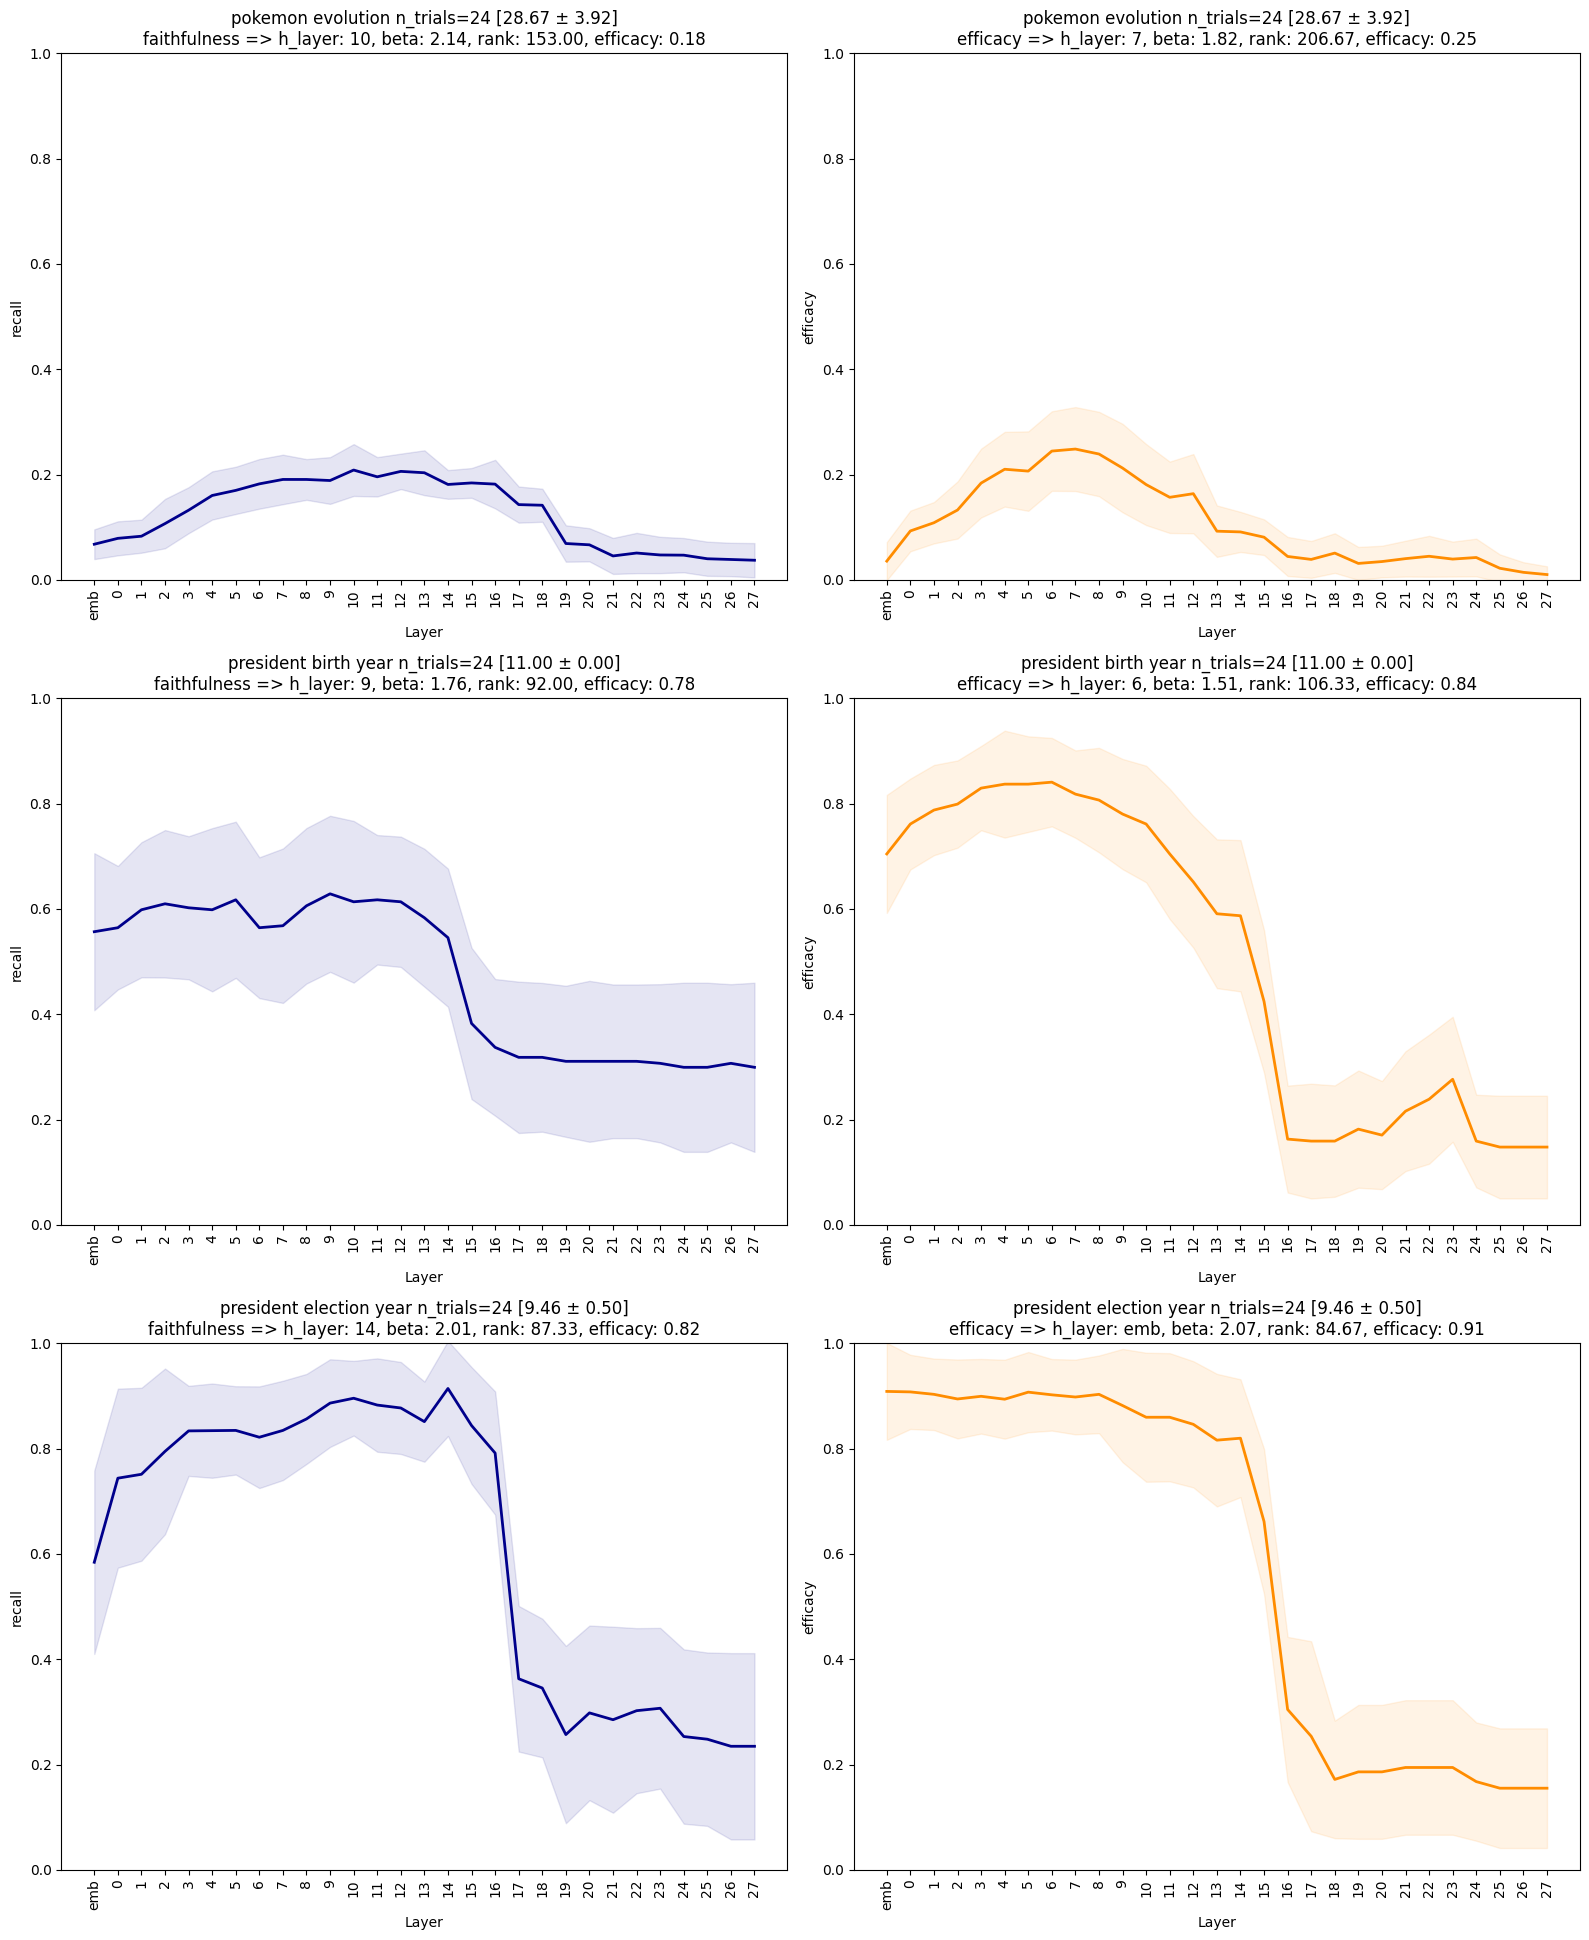

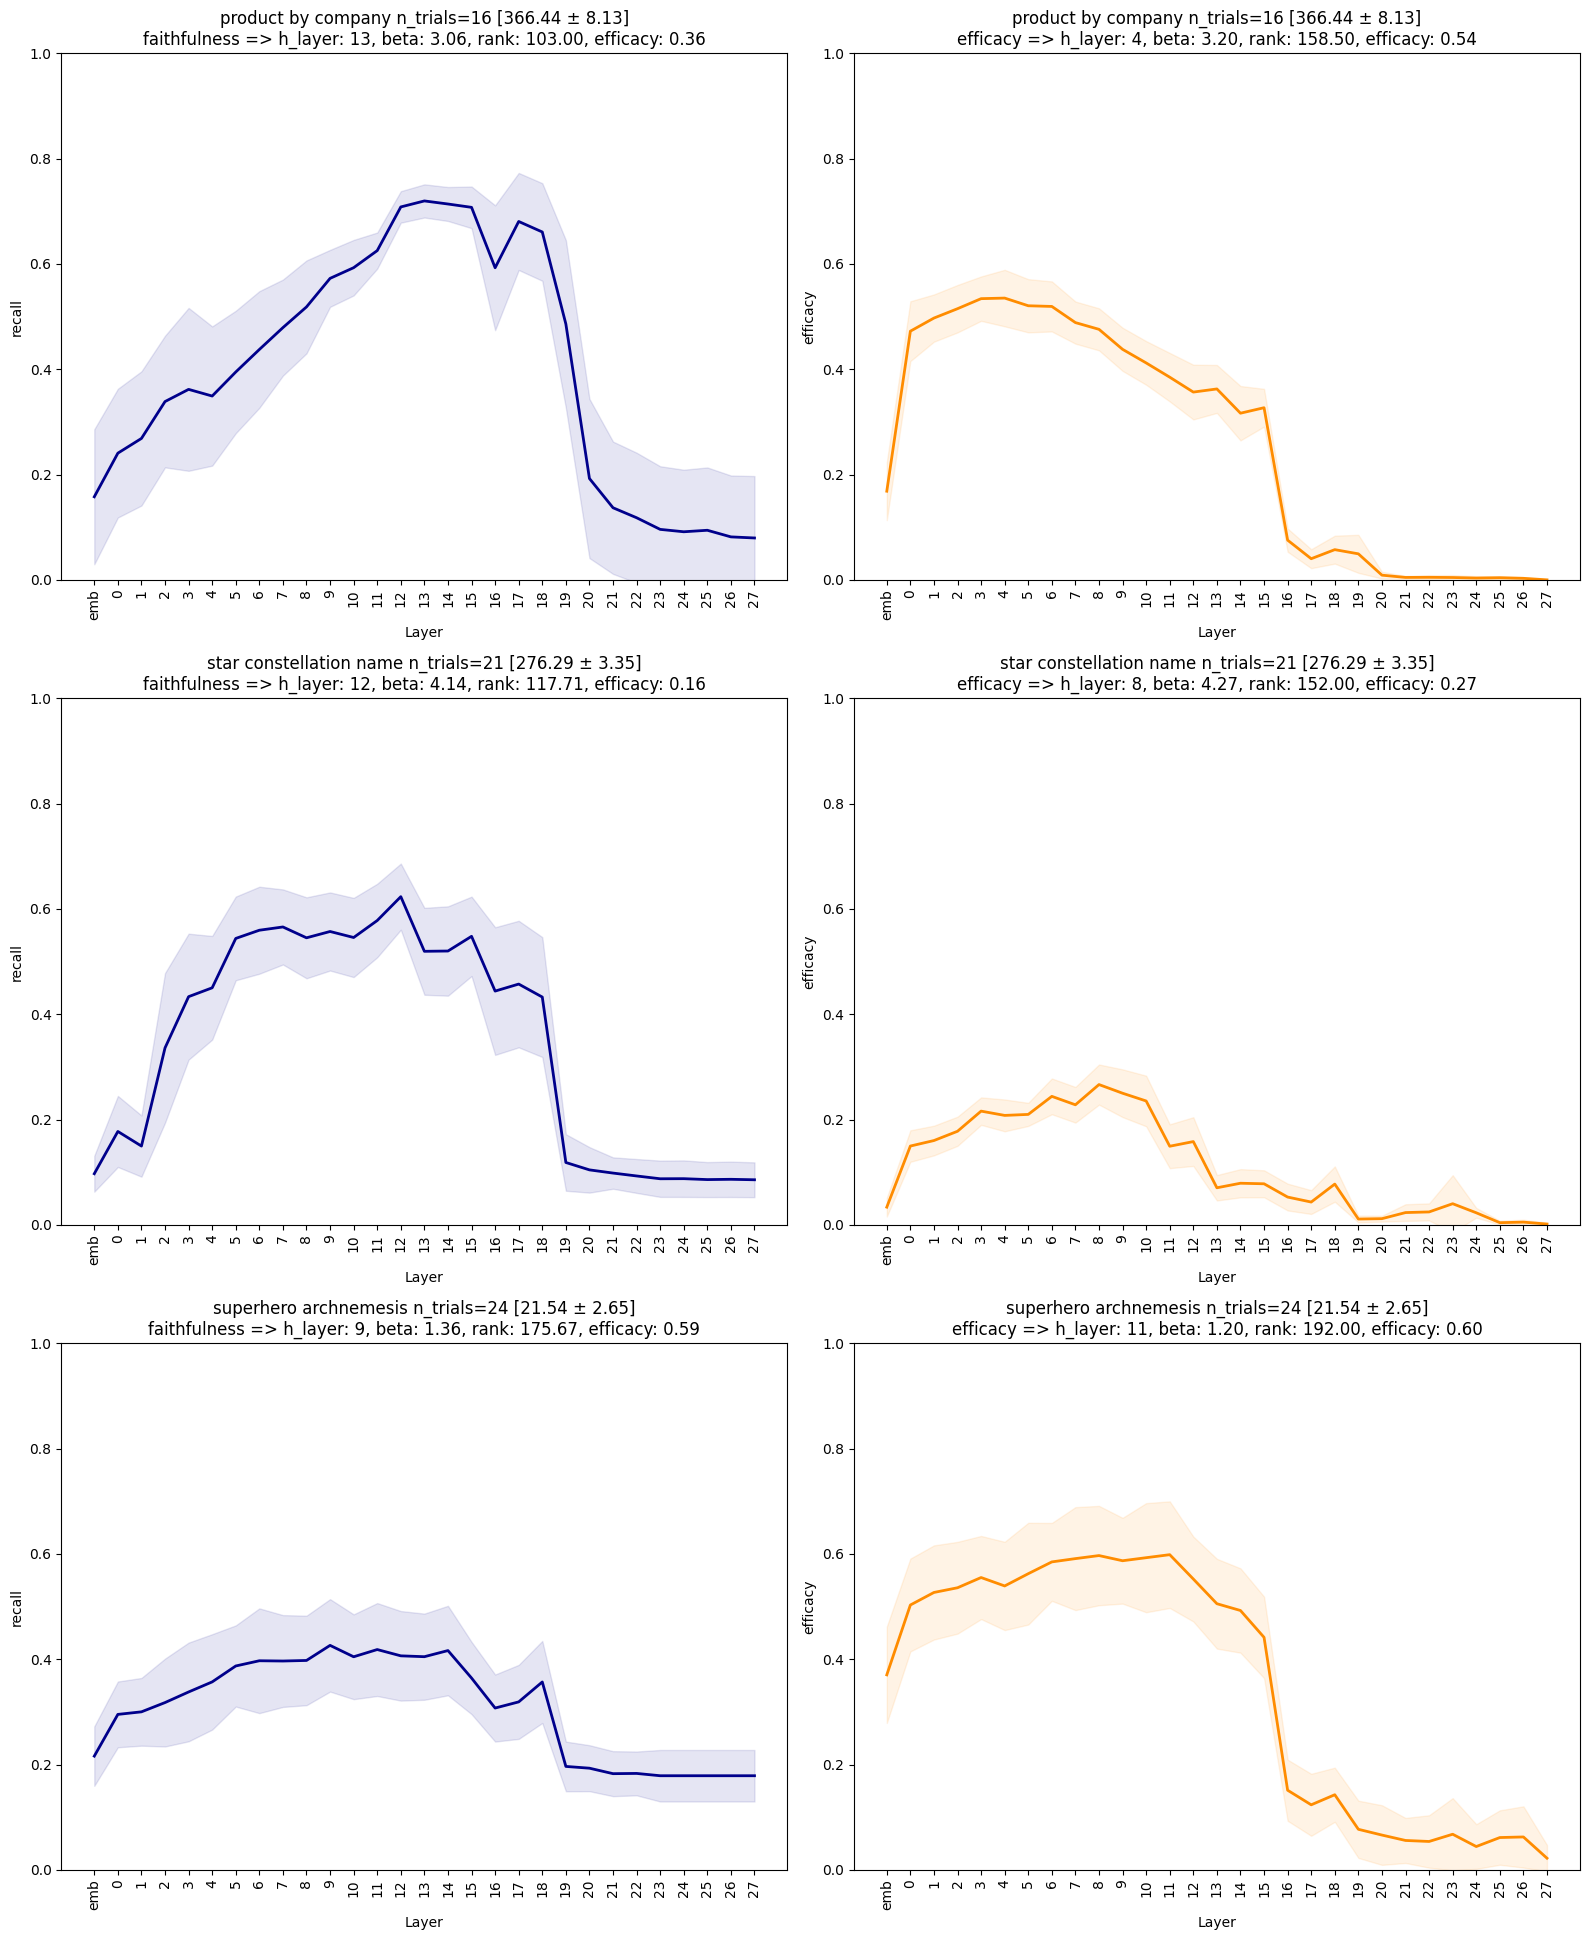

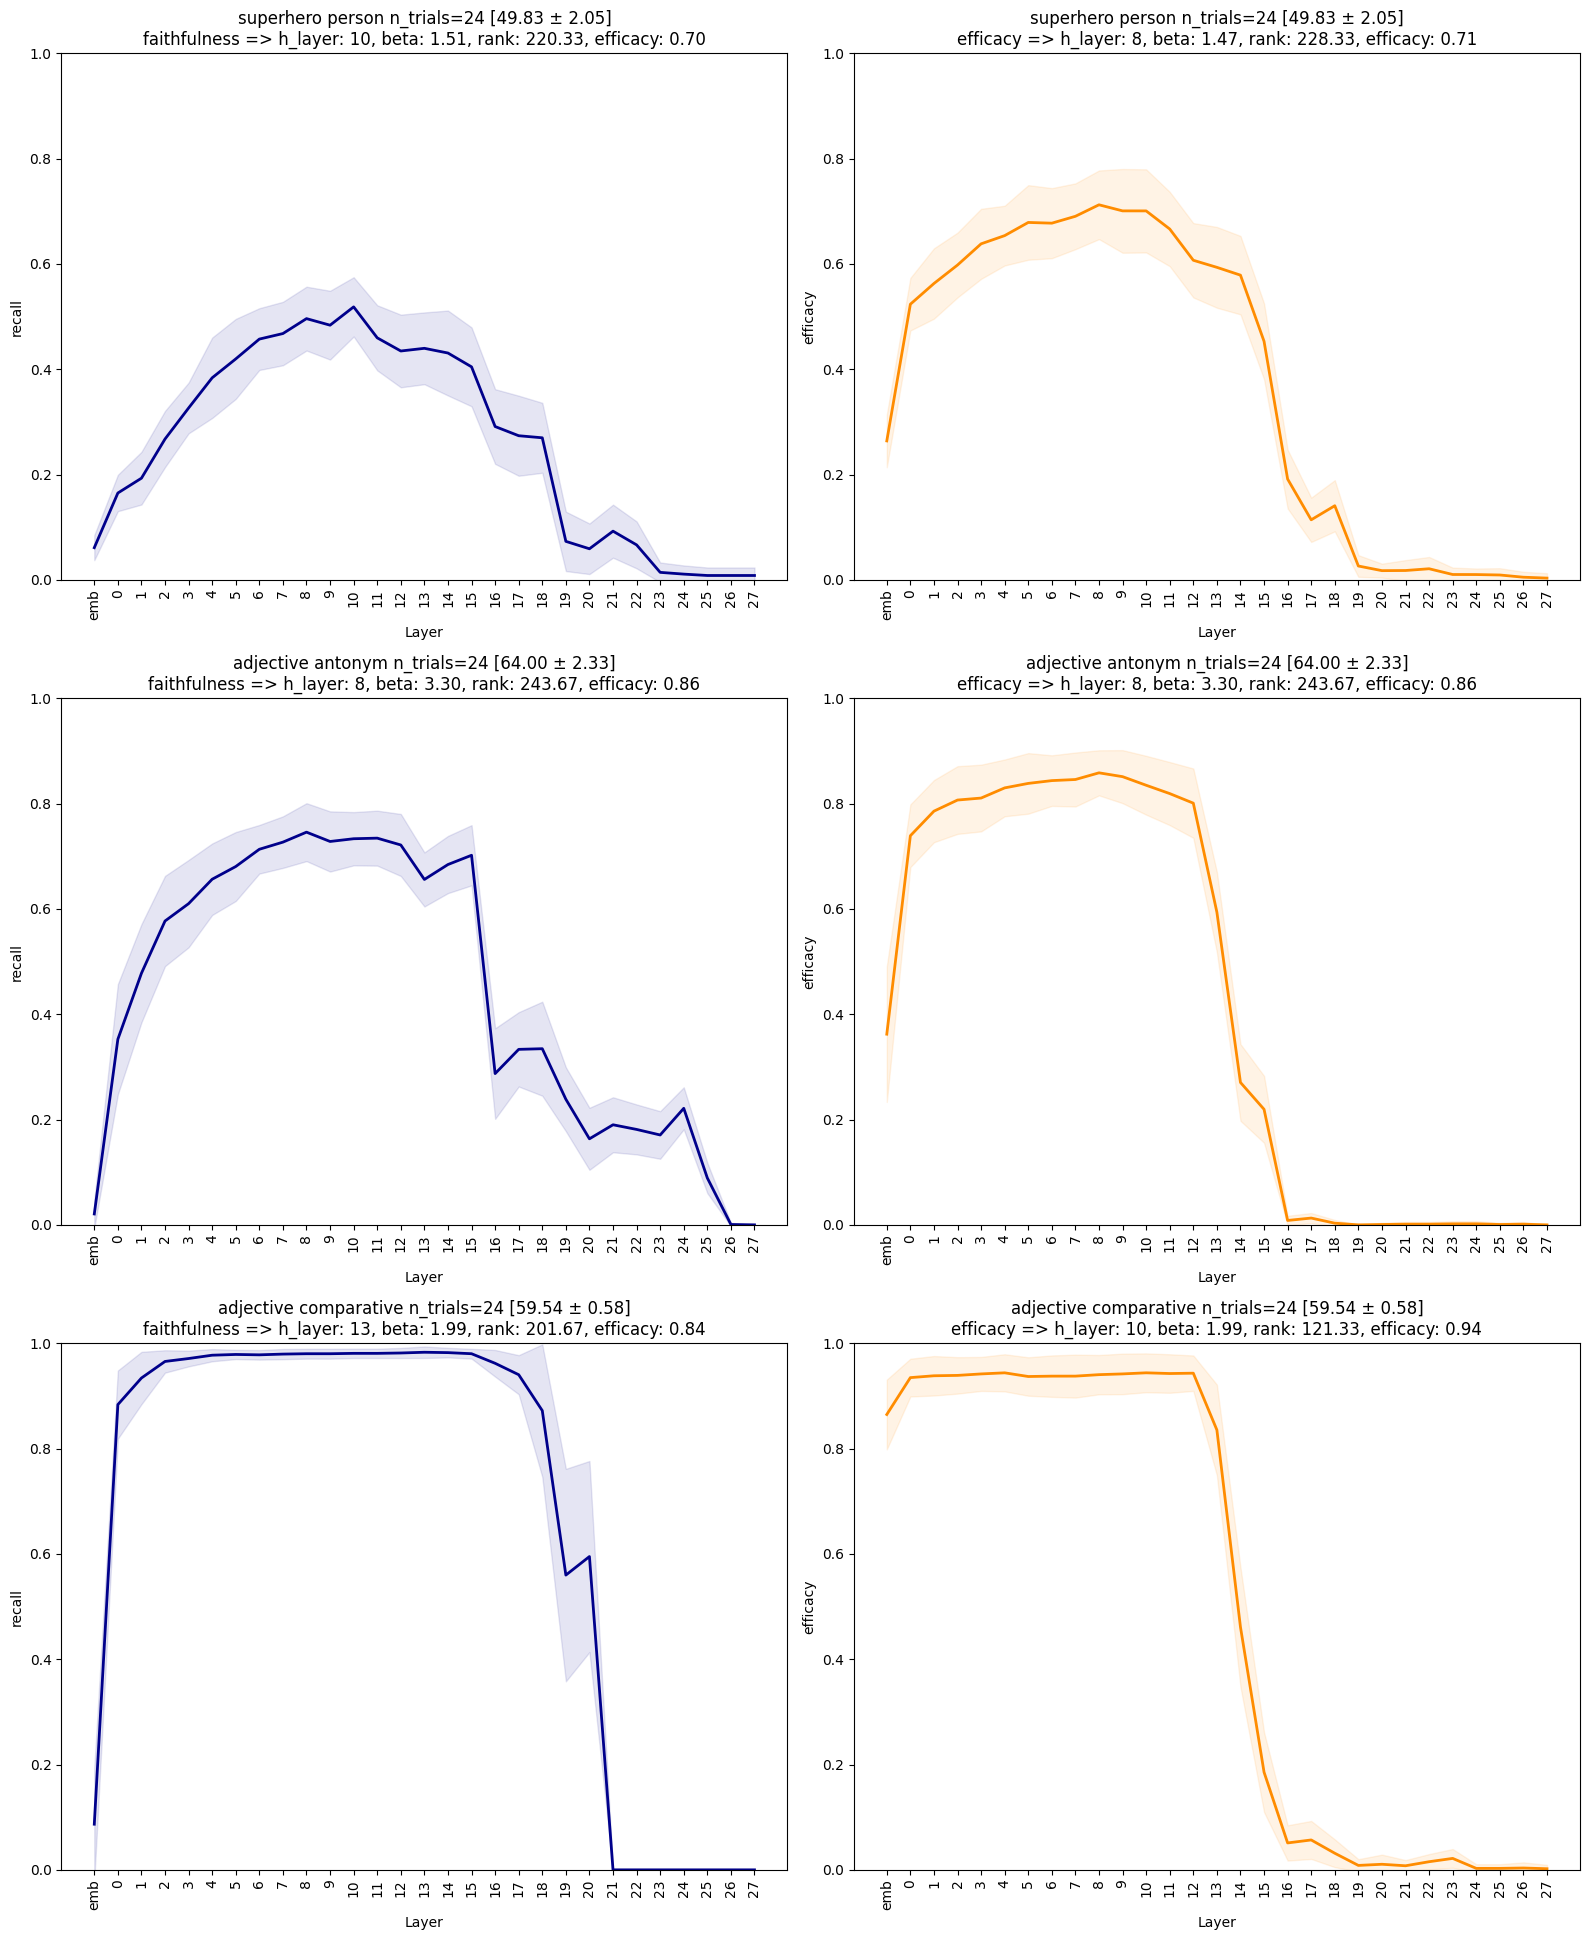

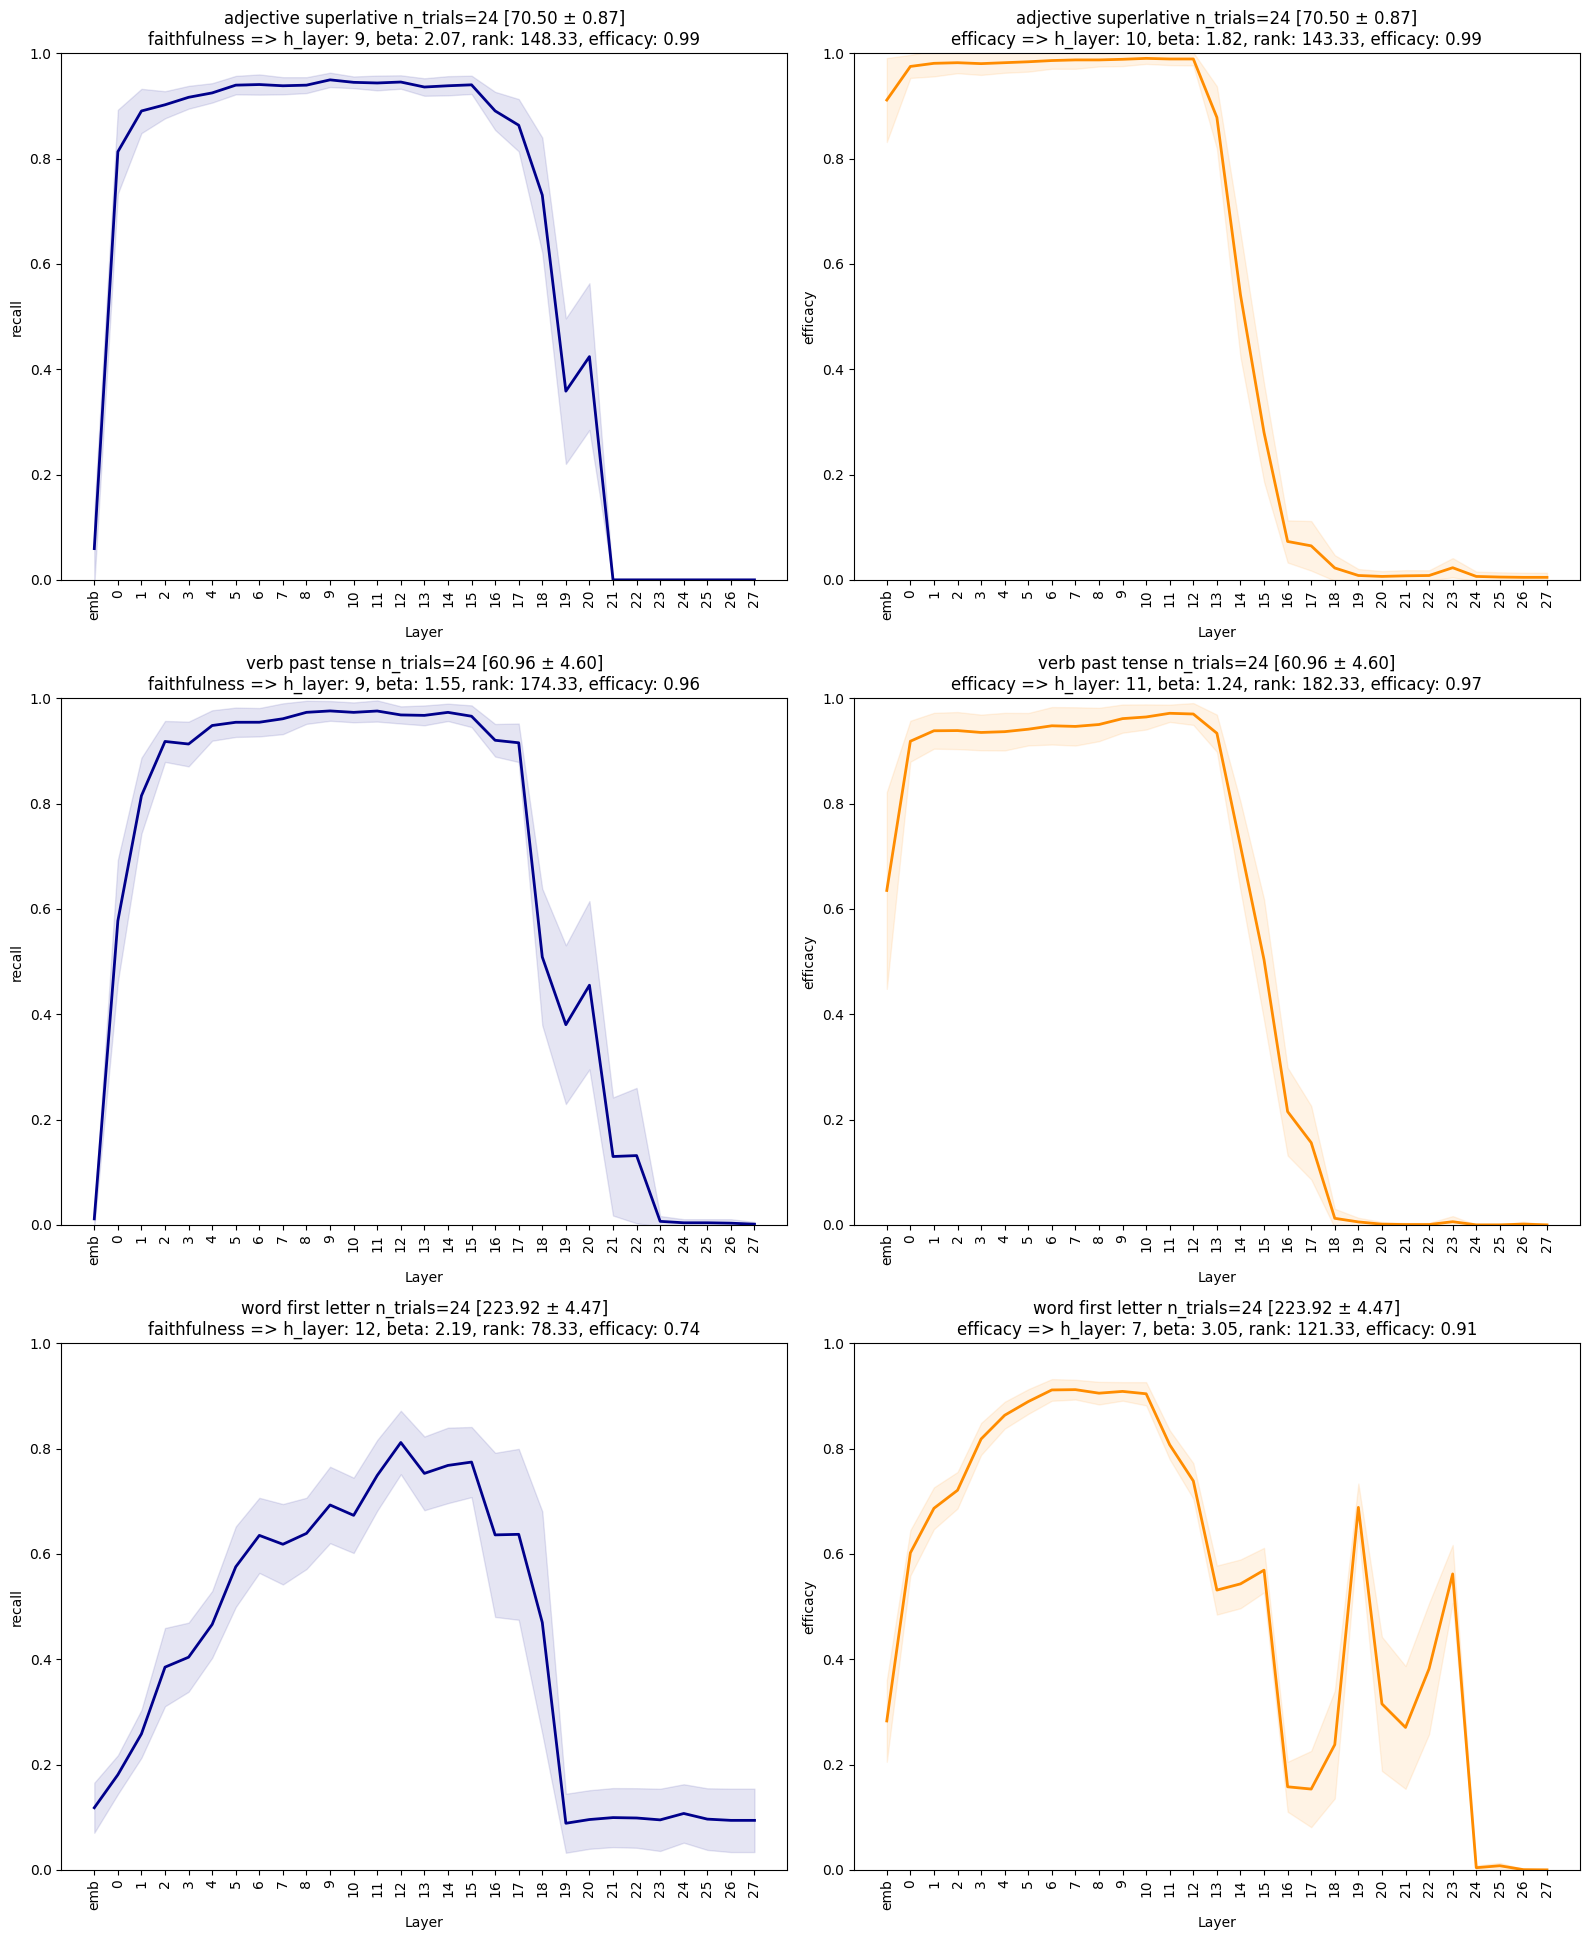

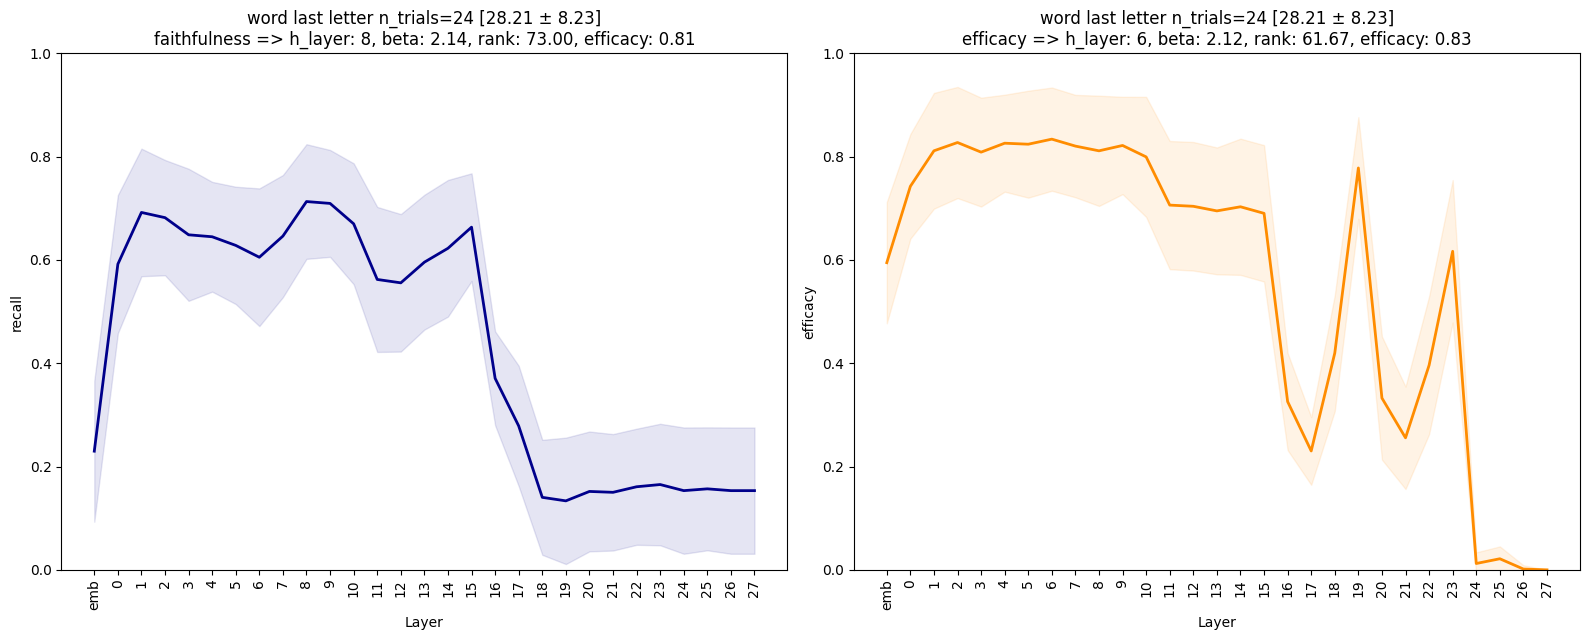

In [22]:
plt.rcdefaults()

step_size = 3

for _from in range(0, len(filtered_results), step_size):
    _to = min(len(filtered_results), _from + step_size)
    n_subplots = len(filtered_results) * 3
    n_subplots = (_to - _from)  * 2
    ncols=2
    nrows=int(np.ceil(n_subplots/ncols))
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 8, nrows * 6.5))
    if n_subplots == 1:
        axes = [axes]
    if nrows == 1:
        axes = [axes]

    ax_col, ax_row = 0, 0
    for i, (relation_name, relation_result) in list(enumerate(filtered_results.items()))[_from  : _to]:
        print(i, relation_name)
        result = filtered_results[relation_name]
        plot_layerwise(axes[ax_row][0], result)
        plot_layerwise(axes[ax_row][1], result, attribute="efficacy", best_criterion="efficacy")
        # if(relation_name in efficacy_baseline_results):
        #     efficacy_baselines = parse_efficacy_baseline_results(efficacy_baseline_results[relation_name])
        #     plot_efficacy_baseline(axes[ax_row][1], efficacy_baselines)
        ax_row += 1

    fig.tight_layout()
    fig.show()

## Causality vs Faithfulness Scatter Plots

In [23]:
def get_recall_vs_efficacy_info(sweep_results, criterion = "best", threshold = 30, beta = None):
    recalls = []
    efficacies = []
    pass_threshold = []
    labels = []
    for relation_name in sweep_results:
        if len(sweep_results[relation_name].trials) == 0:
            continue
        if criterion in ["best", "faithfulness"]:
            recalls.append(sweep_results[relation_name].best_by_faithfulness(beta = beta).recall.mean)
        else:
            recalls.append(sweep_results[relation_name].best_by_efficacy(beta = beta).recall.mean)
        if criterion in ["best", "efficacy"]:
            efficacies.append(sweep_results[relation_name].best_by_efficacy().efficacy.mean)
        else:
            efficacies.append(sweep_results[relation_name].best_by_faithfulness().efficacy.mean)
        
        test_samples = np.array([trial.n_test_samples for trial in sweep_results[relation_name].trials])
        pass_threshold.append(test_samples.min() >= threshold)
        labels.append(relation_name)

    return recalls, efficacies, pass_threshold, labels

/tmp/ipykernel_14160/938723771.py:22: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


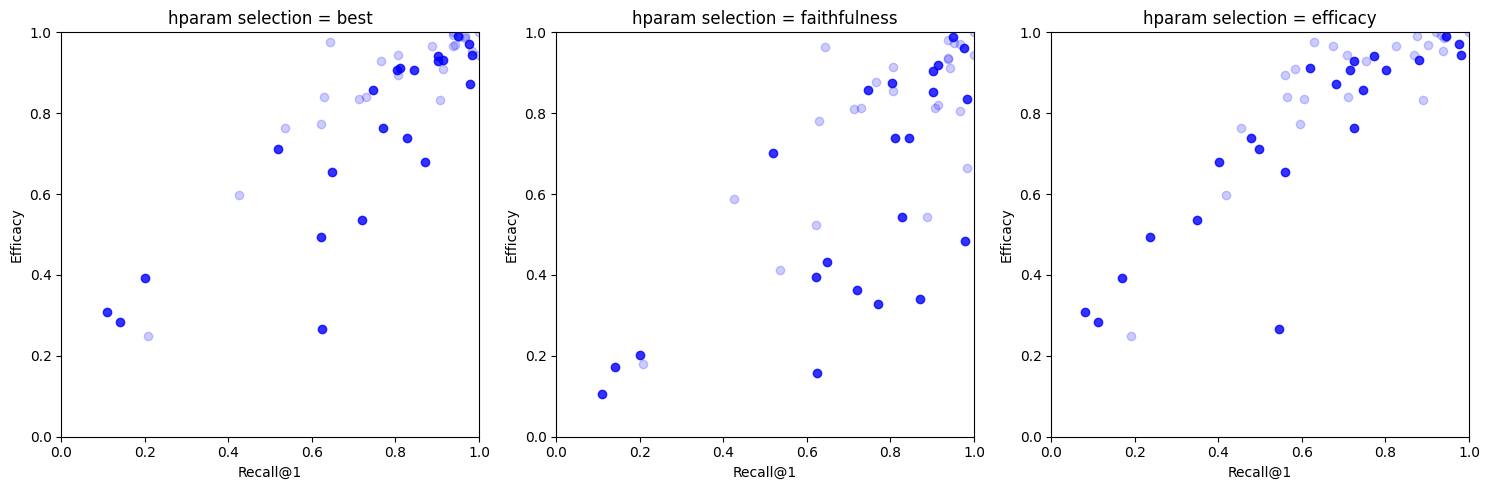

In [24]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

for criterion, ax in zip(["best", "faithfulness", "efficacy"], axes):
    recalls, efficacies, pass_threshold, labels = get_recall_vs_efficacy_info(
        filtered_results, criterion=criterion, 
        # beta = 2.25
    )
    for recall, efficacy, threshold, relation_name in zip(recalls, efficacies, pass_threshold, labels):
        alpha = .8 if threshold else 0.2
        ax.scatter(recall, efficacy, color="blue", alpha=alpha)
        # if threshold and (recall/efficacy < .7 or efficacy/recall < .7):
        #     ax.annotate(relation_name, (recall, efficacy))


    ax.set_title(f"hparam selection = {criterion}")
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_xlabel("Recall@1")
    ax.set_ylabel("Efficacy")

fig.tight_layout()
fig.show()

In [25]:
recalls, efficacies, pass_threshold, labels = get_recall_vs_efficacy_info(
    filtered_results, criterion=criterion, 
    beta = 4
)
correlation = np.corrcoef(recalls, efficacies)[0, 1]
correlation

0.7640005272135588

In [26]:
from sklearn.linear_model import LinearRegression
import torch

def get_linear_model(recalls: list[float], efficacies: list[float]):
    X = torch.Tensor(recalls)[None].T
    y = torch.Tensor(efficacies)[None].T
    lm = LinearRegression().fit(X = X, y = y)
    slope = torch.Tensor(lm.coef_).squeeze().item()
    y_intercept = torch.Tensor(lm.intercept_).squeeze().item()
    r_squared = lm.score(X, y)
    return slope, y_intercept, r_squared



In [27]:
beta_options = [beta.beta for beta in relation_result.trials[0].layers[0].result.betas]
# beta_options

beta=0.0 | r_squared=0.09, slope=0.330, y_intercept=0.751
beta=0.25 | r_squared=0.11, slope=0.330, y_intercept=0.738
beta=0.5 | r_squared=0.14, slope=0.344, y_intercept=0.713
beta=0.75 | r_squared=0.23, slope=0.414, y_intercept=0.660
beta=1.0 | r_squared=0.33, slope=0.474, y_intercept=0.601
beta=1.25 | r_squared=0.45, slope=0.563, y_intercept=0.529
beta=1.5 | r_squared=0.57, slope=0.647, y_intercept=0.458
beta=1.75 | r_squared=0.64, slope=0.682, y_intercept=0.418
beta=2.0 | r_squared=0.68, slope=0.707, y_intercept=0.393
beta=2.25 | r_squared=0.71, slope=0.732, y_intercept=0.374
beta=2.5 | r_squared=0.71, slope=0.738, y_intercept=0.369
beta=2.75 | r_squared=0.71, slope=0.735, y_intercept=0.372
beta=3.0 | r_squared=0.68, slope=0.722, y_intercept=0.383
beta=3.25 | r_squared=0.66, slope=0.707, y_intercept=0.397
beta=3.5 | r_squared=0.64, slope=0.691, y_intercept=0.412
beta=3.75 | r_squared=0.61, slope=0.673, y_intercept=0.428
beta=4.0 | r_squared=0.58, slope=0.653, y_intercept=0.446
beta=4

/tmp/ipykernel_14160/561082002.py:46: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


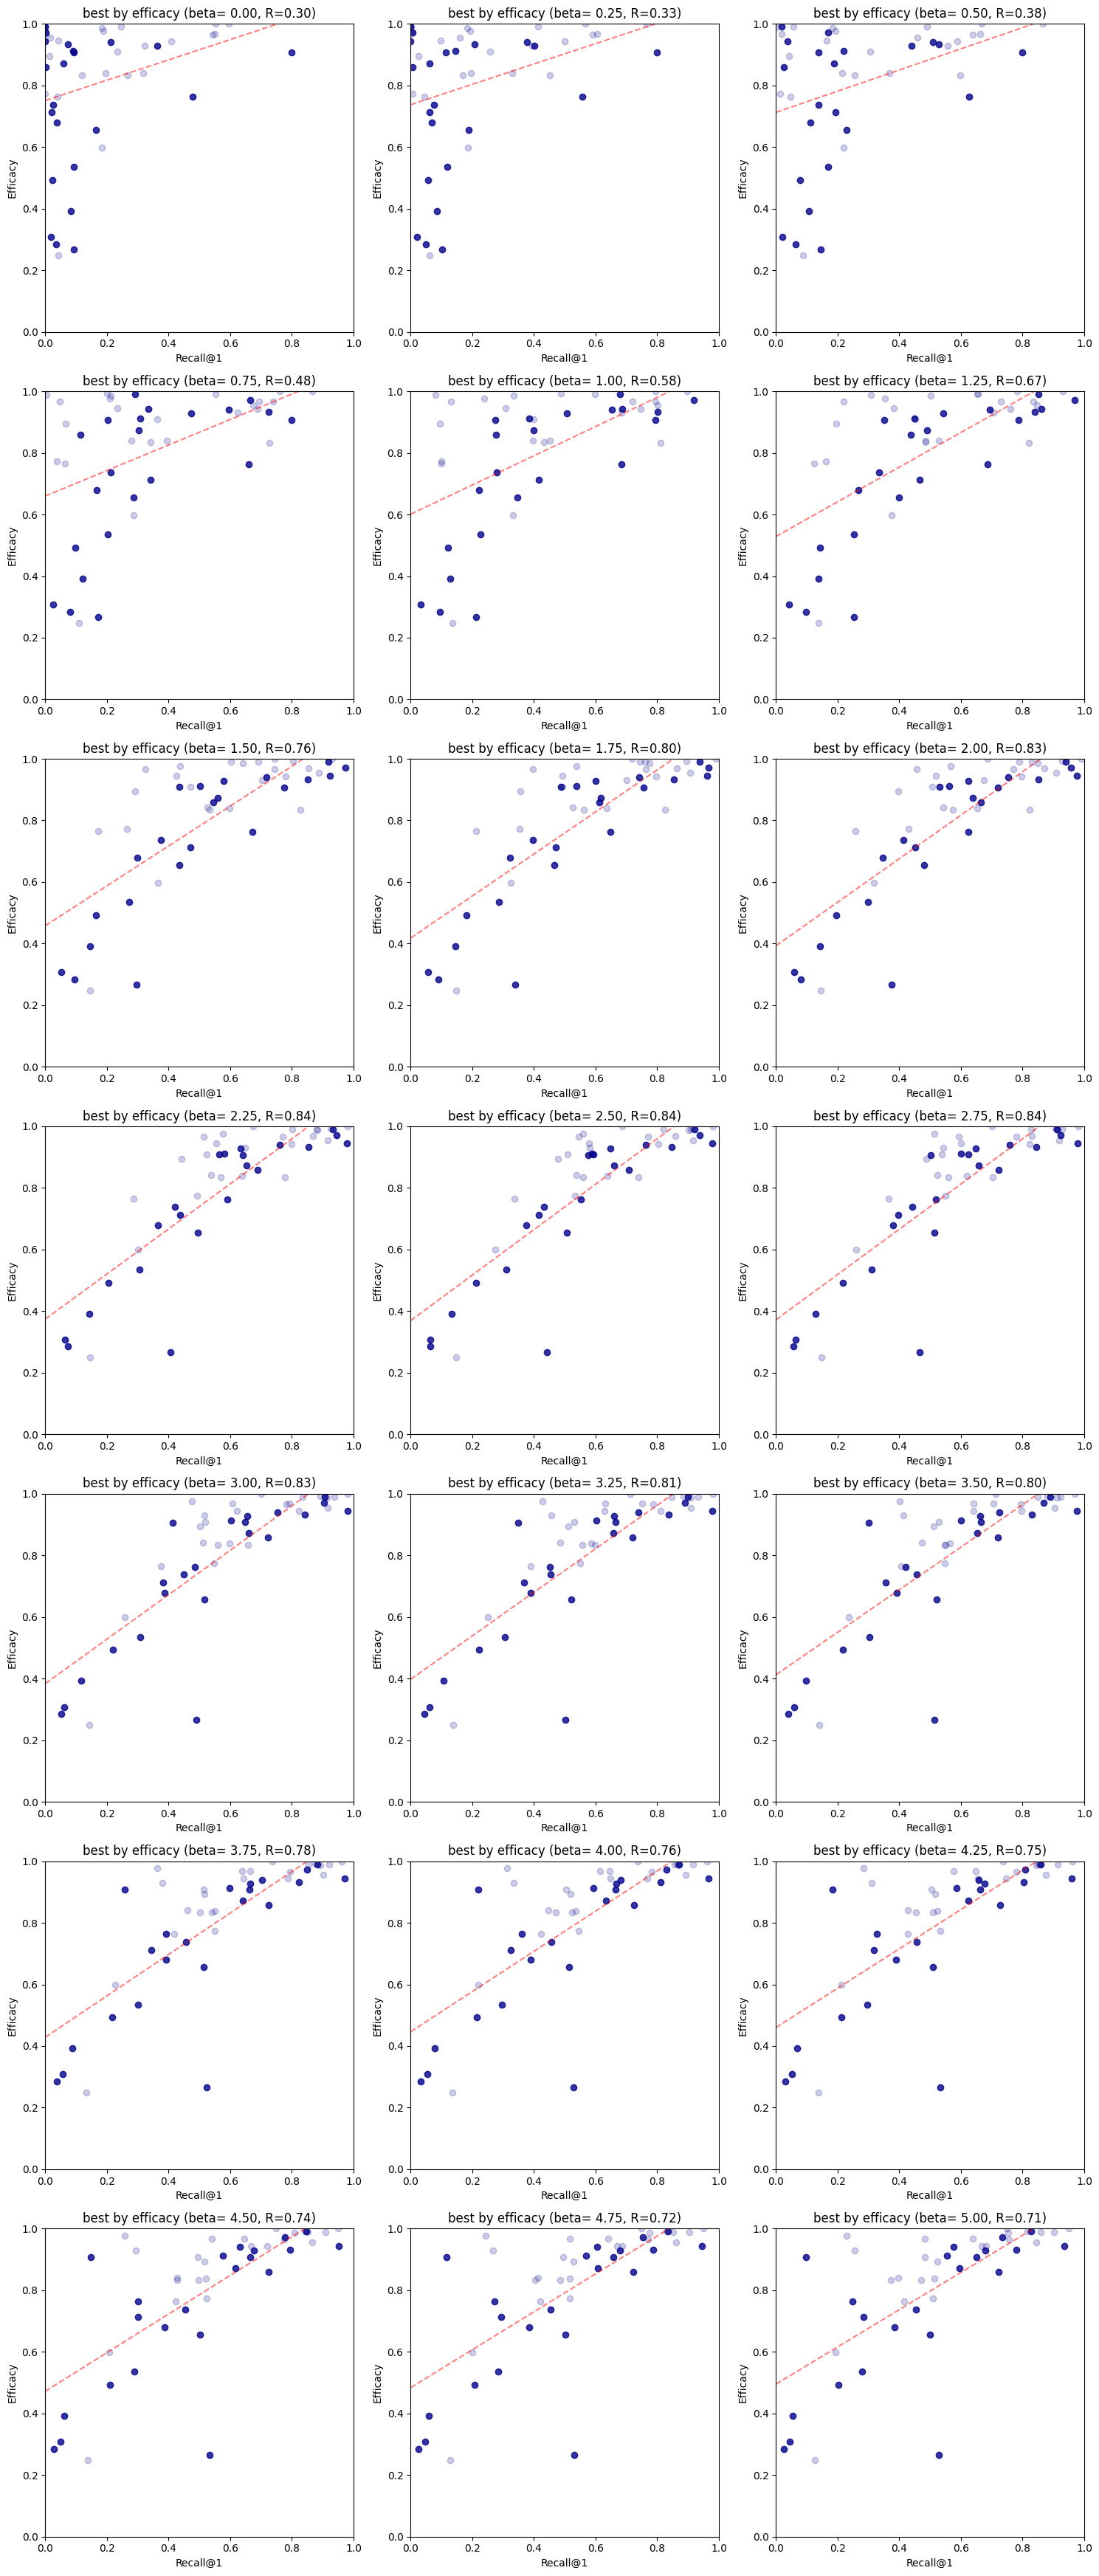

In [28]:
plt.rcdefaults()
num_figs = len(beta_options)
n_cols = 3
n_rows = int(np.ceil(num_figs/n_cols))
fig, axes = plt.subplots(nrows=n_rows, ncols=3, figsize=(5*n_cols, 5*n_rows))

scores_by_beta = []
cur_row, cur_col = 0, 0
for i, beta in enumerate(beta_options):
    recalls, efficacies, pass_threshold, labels = get_recall_vs_efficacy_info(filtered_results, criterion="efficacy", beta = beta)
    correlation = np.corrcoef(recalls, efficacies)[0, 1]

    scores_by_beta.append({
        "beta": f"{beta:.2f}",
        "recall_mean": f"{np.mean(recalls):.2f} ± {np.std(recalls):.2f}",
        "efficacy_mean": f"{np.mean(efficacies):.2f} ± {np.std(efficacies):.2f}",
        "R": f"{correlation:.2f}"
    })

    for recall, efficacy, threshold, relation_name in zip(recalls, efficacies, pass_threshold, labels):
        alpha = .8 if threshold else 0.2
        axes[cur_row][cur_col].scatter(recall, efficacy, color="darkblue", alpha=alpha)
        # if threshold and (recall/efficacy < .6 or efficacy/recall < .6):
        #     plt.annotate(relation_name, (recall, efficacy))

    slope, y_intercept, r_squared = get_linear_model(recalls, efficacies)

    print(f"{beta=} | {r_squared=:.2f}, {slope=:.3f}, {y_intercept=:.3f}")
    x = np.linspace(0, 1, 10)
    axes[cur_row][cur_col].plot(x, slope*x + y_intercept, color="red", linestyle="--", alpha=0.5)
    axes[cur_row][cur_col].set_title(
        f"best by efficacy (beta={beta : .2f}, R={correlation:.2f})", 
        # fontsize=BIGGER_SIZE
    )
    axes[cur_row][cur_col].set_xlim(0, 1)
    axes[cur_row][cur_col].set_ylim(0, 1)
    axes[cur_row][cur_col].set_xlabel("Recall@1")
    axes[cur_row][cur_col].set_ylabel("Efficacy")

    cur_col += 1
    if cur_col == n_cols:
        cur_row += 1
        cur_col = 0

fig.tight_layout()
fig.show()

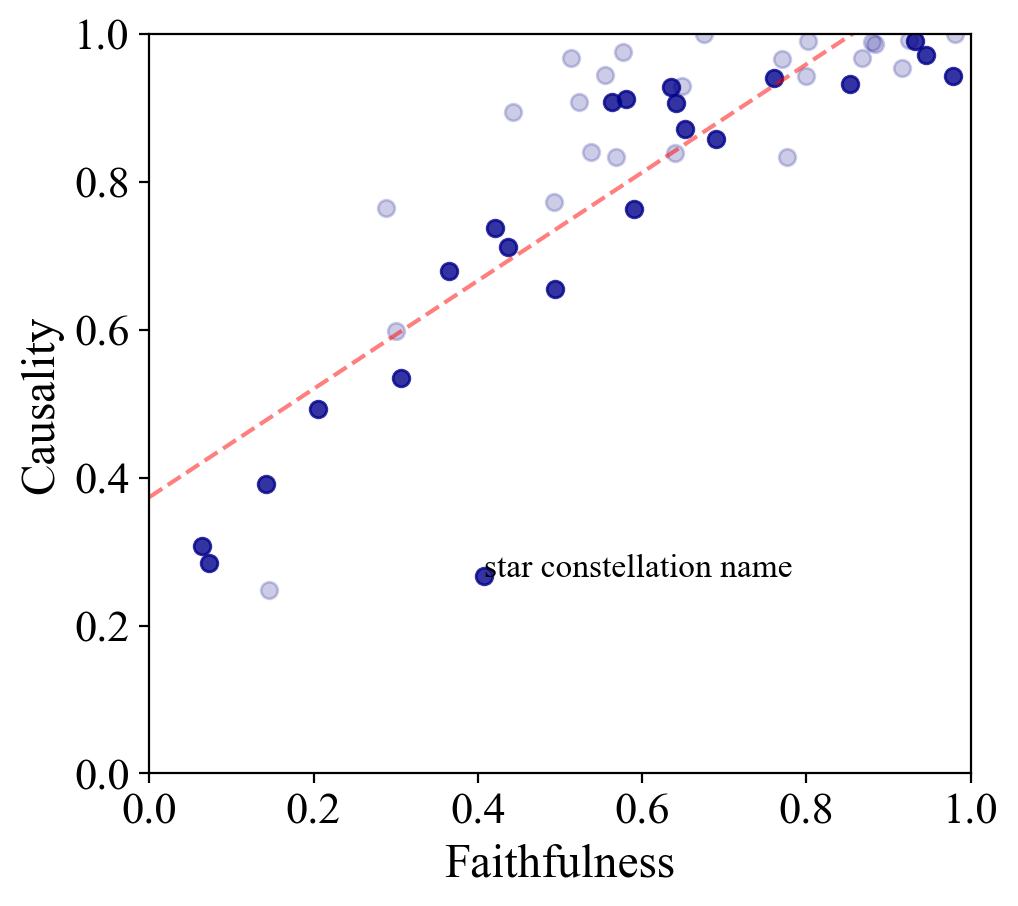

In [29]:
#####################################################################################
plt.rcdefaults()
plt.rcParams["figure.dpi"] = 200
plt.rcParams["font.family"] = "Times New Roman"

SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", labelsize=MEDIUM_SIZE+1)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("figure", titlesize=50)  # fontsize of the figure title
#####################################################################################

# plt.rcdefaults()


recalls, efficacies, pass_threshold, labels = get_recall_vs_efficacy_info(filtered_results, criterion="efficacy", beta=2.25)
correlation = np.corrcoef(recalls, efficacies)[0, 1]

x = np.linspace(0, 1, 10)
slope, y_intercept, r_squared = get_linear_model(recalls, efficacies)
plt.plot(x, slope*x + y_intercept, color="red", linestyle="--", alpha=0.5)

for recall, efficacy, threshold, relation_name in zip(recalls, efficacies, pass_threshold, labels):
    alpha = .8 if threshold else 0.2
    # plt.scatter(recall, efficacy, color="darkblue", alpha=alpha)
    plt.scatter(recall, efficacy, color="darkblue", alpha=alpha)
    dist = np.abs(slope * recall - efficacy + y_intercept)/(slope**2 + 1)**.5
    if dist > 0.2:
        plt.annotate(relation_name, (recall, efficacy))

# plt.title(
#     f"Faithfulness vs Causality", # (Correlation={correlation :.2f})", 
#     fontsize=BIGGER_SIZE
# )
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel("Faithfulness")
plt.ylabel("Causality")
plt.gca().set_aspect('.9')
plt.savefig(f"{fig_dir}/{model_name}-efficacy_vs_faithfulness.pdf", bbox_inches="tight")

plt.show()

In [30]:
import pandas as pd
df = pd.DataFrame(scores_by_beta)
# print(df[["beta", "recall_mean", "R"]].style.hide_index().to_latex())
os.makedirs("../../results/tables", exist_ok=True)
df.to_csv(f"../../results/tables/{model_name}-beta-R.csv", index=False)
df

beta  recall_mean efficacy_mean     R
0   0.00  0.17 ± 0.20   0.81 ± 0.22  0.30
1   0.25  0.21 ± 0.22   0.81 ± 0.22  0.33
2   0.50  0.28 ± 0.24   0.81 ± 0.22  0.38
3   0.75  0.36 ± 0.25   0.81 ± 0.22  0.48
4   1.00  0.43 ± 0.26   0.81 ± 0.22  0.58
5   1.25  0.50 ± 0.26   0.81 ± 0.22  0.67
6   1.50  0.54 ± 0.25   0.81 ± 0.22  0.76
7   1.75  0.57 ± 0.25   0.81 ± 0.22  0.80
8   2.00  0.59 ± 0.25   0.81 ± 0.22  0.83
9   2.25  0.59 ± 0.25   0.81 ± 0.22  0.84
10  2.50  0.59 ± 0.25   0.81 ± 0.22  0.84
11  2.75  0.59 ± 0.25   0.81 ± 0.22  0.84
12  3.00  0.59 ± 0.25   0.81 ± 0.22  0.83
13  3.25  0.58 ± 0.25   0.81 ± 0.22  0.81
14  3.50  0.57 ± 0.25   0.81 ± 0.22  0.80
15  3.75  0.56 ± 0.25   0.81 ± 0.22  0.78
16  4.00  0.55 ± 0.25   0.81 ± 0.22  0.76
17  4.25  0.54 ± 0.25   0.81 ± 0.22  0.75
18  4.50  0.53 ± 0.25   0.81 ± 0.22  0.74
19  4.75  0.53 ± 0.25   0.81 ± 0.22  0.72
20  5.00  0.52 ± 0.25   0.81 ± 0.22  0.71

## Faithfulness

In [31]:
model_name_dict = {
    "gpt2-xl": "GPT2-xl",
    "gptj": "GPT-J",
    "llama-13b": "LLaMa-13B",
}

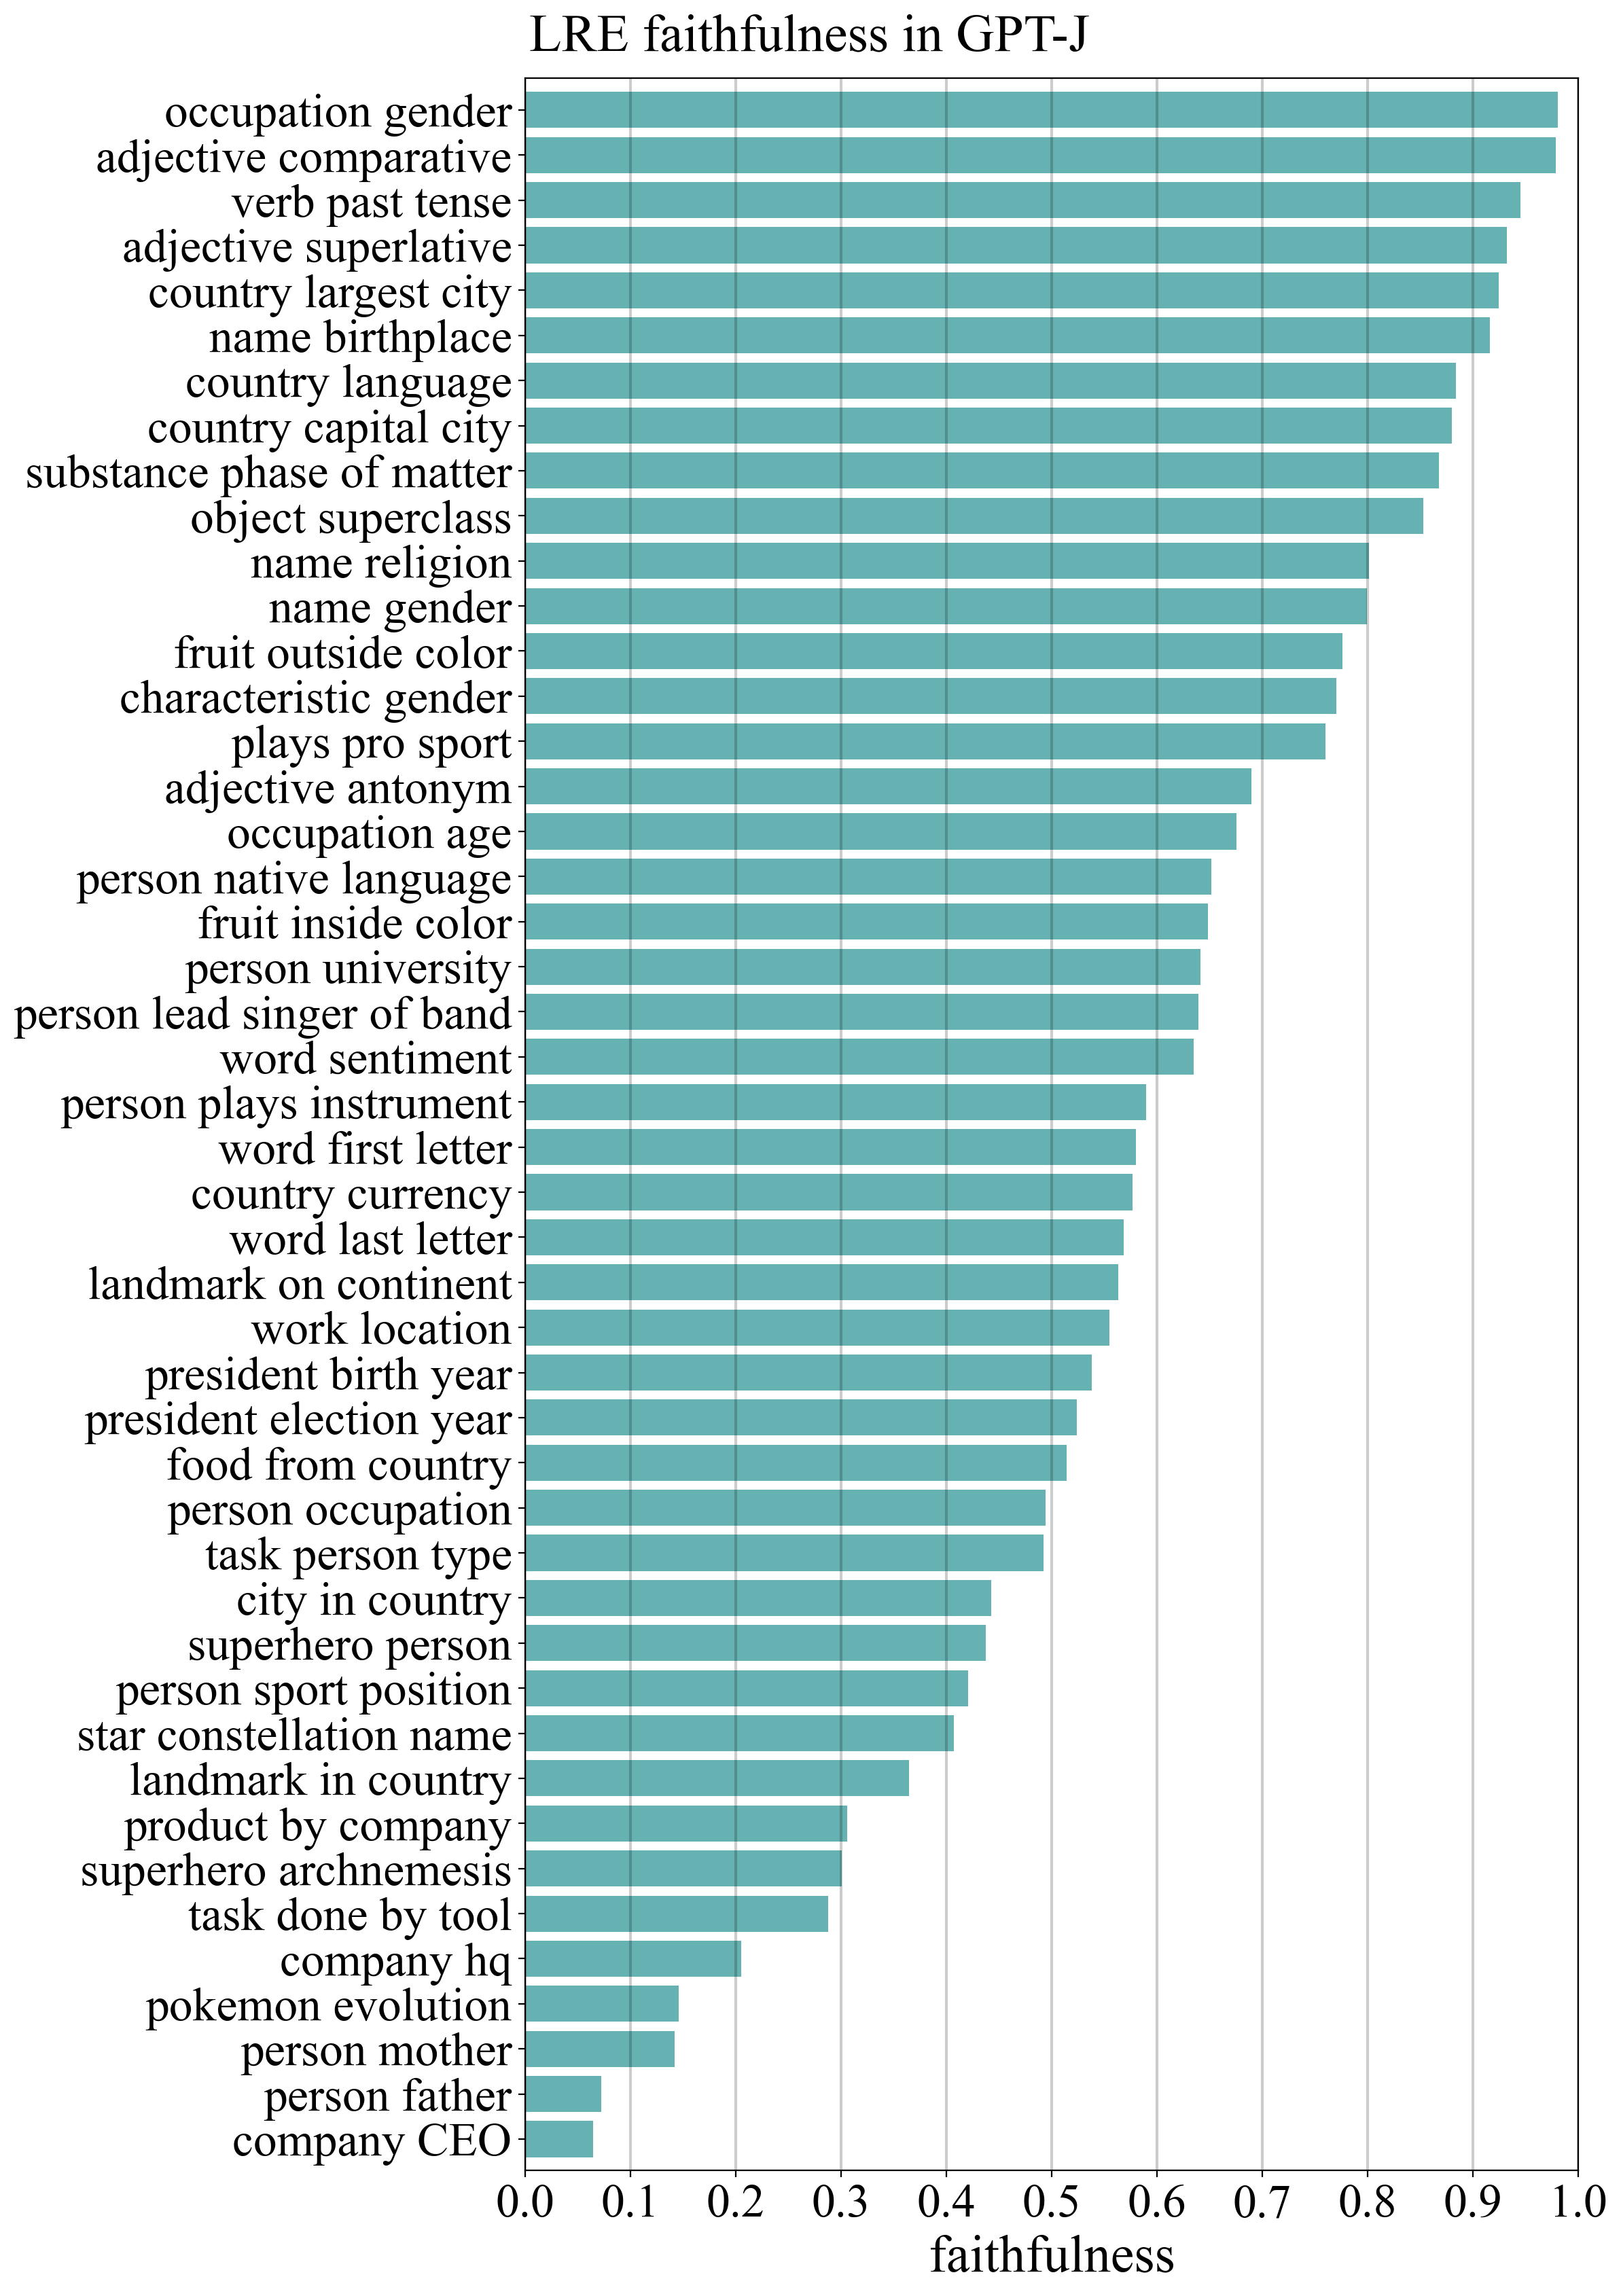

In [32]:
#####################################################################################
plt.rcdefaults()
plt.rcParams["figure.dpi"] = 200
plt.rcParams["font.family"] = "Times New Roman"

SMALL_SIZE = 15
MEDIUM_SIZE = 25
BIGGER_SIZE = 28

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", labelsize=BIGGER_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title

relation_and_recall = []

for relation_name in filtered_results:
    relation_and_recall.append({
        "relation": relation_name,
        "recall@1": filtered_results[relation_name].best_by_efficacy(beta = 2.25).recall.mean
    })

relation_and_recall = sorted(relation_and_recall, key = lambda x: x["recall@1"])

relations = [r["relation"] for r in relation_and_recall]
recalls = [r["recall@1"] for r in relation_and_recall]

plt.figure(figsize = (10, 20))
plt.barh(np.arange(len(relations)), recalls, color = "teal", alpha = 0.6)
plt.yticks(np.arange(len(relations)), relations)
plt.xticks(np.linspace(0, 1, 11), [np.round(v, 1) for v in np.linspace(0, 1, 11)])
plt.ylim(-0.7,len(relation_and_recall)-.3)
plt.xlabel("faithfulness")
plt.xlim(0, 1)

for x_tick in np.linspace(0, 1, 11):
    plt.axvline(x_tick, color = "black", alpha = 0.2)

plt.title(f"LRE faithfulness in {model_name_dict[model_name]}", x = 0.27, pad=15, fontsize=BIGGER_SIZE)
plt.savefig(f"{fig_dir}/{model_name}-faithfulness_lre_relationwise.pdf", bbox_inches="tight")
plt.show()

## Generate Table

In [33]:
table = []
dataset = data.load_dataset()

for relation_name, sweep_result in filtered_results.items():
    efficacy_hparams = sweep_result.best_by_efficacy(beta=2.25)
    relation = dataset.filter(
        relation_names=[relation_name]
    )[0]
    table.append({
        "relation": relation_name,
        "layer": efficacy_hparams.layer,
        "beta": f"{efficacy_hparams.beta.mean: .2f} ± {efficacy_hparams.beta.stdev: .2f}",
        "rank": f"{efficacy_hparams.rank.mean: .2f} ± {efficacy_hparams.rank.stdev: .2f}",
        "recall@1": f"{efficacy_hparams.recall.mean: .2f} ± {efficacy_hparams.recall.stdev: .2f}",
        "efficacy": f"{efficacy_hparams.efficacy.mean: .2f} ± {efficacy_hparams.efficacy.stdev: .2f}",
        # "n_range": f"{len(relation.range)}",
    })

In [34]:
# sorted_table = sorted(table, key=lambda x: x["efficacy"], reverse=True)
sorted_table = sorted(table, key=lambda x: x["relation"])

In [35]:
df = pd.DataFrame(sorted_table)
os.makedirs("../../results/tables", exist_ok=True)
df.to_csv(f"../../results/tables/{model_name}-hparams.csv", index=False)
# print(df.to_markdown(index = False, tablefmt="github"))
# print(df.to_latex(index=False, escape=False))
df

relation layer           beta              rank  \
0            adjective antonym     8   2.25 ±  0.00   243.67 ±  57.08   
1        adjective comparative    10   2.25 ±  0.00   121.33 ±  31.97   
2        adjective superlative    10   2.25 ±  0.00   143.33 ±  48.82   
3        characteristic gender     1   2.25 ±  0.00    74.00 ±  70.59   
4              city in country     2   2.25 ±  0.00   115.33 ±  58.92   
5                  company CEO     6   2.25 ±  0.00   173.33 ±  58.00   
6                   company hq     6   2.25 ±  0.00   126.22 ±  25.09   
7         country capital city     3   2.25 ±  0.00    68.67 ±  43.57   
8             country currency     3   2.25 ±  0.00    88.67 ±  44.48   
9             country language     1   2.25 ±  0.00    63.33 ±  57.13   
10        country largest city    10   2.25 ±  0.00    74.67 ±  48.37   
11           food from country     3   2.25 ±  0.00   113.00 ±  73.33   
12          fruit inside color     7   2.25 ±  0.00   107.50 ±  71.55   
13         fruit outside color     5   2.25 ±  0.00   160.35 ±  79.95   
14         landmark in country     6   2.25 ±  0.00    97.78 ±  28.17   
15       landmark on continent     4   2.25 ±  0.00   158.67 ±  42.44   
16             name birthplace     7   2.25 ±  0.00    91.64 ±  37.42   
17                 name gender   emb   2.25 ±  0.00     17.67 ±  5.15   
18               name religion     4   2.25 ±  0.00    57.00 ±  56.16   
19           object superclass     7   2.25 ±  0.00    91.33 ±  63.28   
20              occupation age     5   2.25 ±  0.00    34.67 ±  32.22   
21           occupation gender     4   2.25 ±  0.00    34.40 ±  31.40   
22               person father     8   2.25 ±  0.00   217.00 ±  51.81   
23  person lead singer of band     8   2.25 ±  0.00   163.67 ±  68.51   
24               person mother     6   2.25 ±  0.00   170.67 ±  46.86   
25      person native language     6   2.25 ±  0.00    92.00 ±  40.46   
26           person occupation     8   2.25 ±  0.00   131.67 ±  55.52   
27     person plays instrument     9   2.25 ±  0.00   198.33 ±  55.09   
28       person sport position     5   2.25 ±  0.00    97.33 ±  54.01   
29           person university     4   2.25 ±  0.00   153.00 ±  83.18   
30             plays pro sport     6   2.25 ±  0.00   117.67 ±  66.19   
31           pokemon evolution     7   2.25 ±  0.00   206.67 ±  69.00   
32        president birth year     6   2.25 ±  0.00   106.33 ±  53.74   
33     president election year   emb   2.25 ±  0.00    84.67 ±  49.15   
34          product by company     4   2.25 ±  0.00   158.50 ±  39.32   
35     star constellation name     8   2.25 ±  0.00   152.00 ±  25.89   
36   substance phase of matter     7   2.25 ±  0.00    60.00 ±  37.45   
37       superhero archnemesis    11   2.25 ±  0.00   192.00 ±  63.87   
38            superhero person     8   2.25 ±  0.00   228.33 ±  63.62   
39           task done by tool     5   2.25 ±  0.00   145.00 ±  57.75   
40            task person type     8   2.25 ±  0.00   109.67 ±  47.92   
41             verb past tense    11   2.25 ±  0.00   182.33 ±  63.20   
42           word first letter     7   2.25 ±  0.00   121.33 ±  48.26   
43            word last letter     6   2.25 ±  0.00    61.67 ±  48.74   
44              word sentiment     4   2.25 ±  0.00    94.67 ±  77.69   
45               work location     5   2.25 ±  0.00   112.67 ±  52.46   

         recall@1       efficacy  
0    0.69 ±  0.07   0.86 ±  0.04  
1    0.98 ±  0.01   0.94 ±  0.04  
2    0.93 ±  0.02   0.99 ±  0.01  
3    0.77 ±  0.11   0.97 ±  0.04  
4    0.44 ±  0.10   0.89 ±  0.09  
5    0.06 ±  0.03   0.31 ±  0.05  
6    0.21 ±  0.06   0.49 ±  0.04  
7    0.88 ±  0.07   0.99 ±  0.02  
8    0.58 ±  0.08   0.98 ±  0.03  
9    0.88 ±  0.09   0.99 ±  0.03  
10   0.92 ±  0.05   0.99 ±  0.02  
11   0.51 ±  0.12   0.97 ±  0.05  
12   0.65 ±  0.15   0.93 ±  0.07  
13   0.78 ±  0.15   0.83 ±  0.12  
14   0.36 ±  0.06   0.68 ±  0.02  
15   0.56 ±  0.13   0.91 ±  0.

### Single vs Multi token subjects

In [36]:
# def read_and_parse_sweep_results(sweep_path):
#     sweep_results = read_sweep_results(sweep_path)
#     for relation in sweep_results:
#         sweep_results[relation] = parse_results(sweep_results[relation])
#     return sweep_results

In [37]:
# sweep_single_path = f"../../results/sweep-single/{model_name}"
# sweep_single = read_and_parse_sweep_results(sweep_single_path)

# sweep_multi_path = f"../../results/sweep-multi/{model_name}"
# sweep_multi = read_and_parse_sweep_results(sweep_multi_path)

In [38]:
# fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 4.5))

# for criterion, ax in zip(["best", "faithfulness", "efficacy"], axes):
#     single_recalls, single_efficacies, pass_single, single_labels = get_recall_vs_efficacy_info(sweep_single, criterion=criterion)
#     multi_recalls, multi_efficacies, pass_multi, multi_labels = get_recall_vs_efficacy_info(sweep_multi, criterion=criterion)
#     labeled = False
#     for r, e, p, l in zip(single_recalls, single_efficacies, pass_single, single_labels):
#         alpha = .8 if p else 0.2
#         if (alpha == 0.8 and not labeled):
#             ax.scatter(r, e, color = "blue", label = "single", alpha = alpha)
#             labeled = True
#         else:
#             ax.scatter(r, e, color = "blue", alpha = alpha)
#         if p and (r/e < .7 or e/r < .7):
#             ax.annotate(l, (r, e))

#     labeled = False
#     for r, e, p, l in zip(multi_recalls, multi_efficacies, pass_multi, multi_labels):
#         alpha = .8 if p else 0.2
#         alpha = .8 if p else 0.2
#         if (alpha == 0.8 and not labeled):
#             ax.scatter(r, e, color = "red", label = "multi", marker = "s", alpha = alpha)
#             labeled = True
#         else:
#             ax.scatter(r, e, color = "red", marker = "s", alpha = alpha)
#         if p and (r/e < .7 or e/r < .7):
#             ax.annotate(l, (r, e))

#     ax.set_title(f"Efficacy vs Recall ({criterion})")
#     ax.set_xlim(0, 1)
#     ax.set_ylim(0, 1)
#     ax.set_xlabel("Recall")
#     ax.set_ylabel("Efficacy")
#     ax.legend()